# Test for bike trafic model

In [109]:
import sys
from pathlib import Path

# Trouve le dossier racine du projet (celui qui contient 'src')
project_root = Path().resolve().parents[0]  # si ton notebook est dans 'notebook/'
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import matplotlib.cm as cm
from matplotlib.lines import Line2D

from aequilibrae.paths import RouteChoice
from aequilibrae.matrix import AequilibraeMatrix
import warnings

warnings.filterwarnings('ignore')

from utils_traffic import *
import logging
logging.getLogger("aequilibrae").setLevel(logging.ERROR)

from pypalettes import load_palette


## Fonction definition

In [138]:
###### preprocessing functions
def set_capacity_cars(edges_df, capacity_per_lane=100, lanes_col='lanes'):
    edges_df['capacity_cars'] = edges_df[lanes_col]*capacity_per_lane
    return edges_df

def set_capacity_bikes(edges_df, capacity_per_lane=200, lanes_col='lanes'):
    edges_df['capacity_bikes'] = edges_df[lanes_col]*capacity_per_lane
    return edges_df

def time_estimation_cars(edges_df):
    travel_time = []
    for _, edge in edges_df.iterrows():
        travel_time.append((edge['length']/1000)/(edge['speed']*0.5))
    edges_df['travel_time_cars'] = travel_time
    return edges_df

def free_flow_time (edges_df, mode):
    name_col = 'free_flow_time_' + mode
    edges_df[name_col] = edges_df['length']/ (edges_df['speed_'+ mode])
    return edges_df

def simple_bi(edges_df, coef = 1):
    length_bi = []
    for _, edge in edges_df.iterrows():
        if edge['type_bike'] == 'bike_lane':
            length_bi.append(edge['length']*0.9*coef)
        elif edge['type_bike'] == 'bike_path':
            length_bi.append(edge['length']*0.5*coef)
        else:
            length_bi.append(edge['length']*2*coef)
    edges_df['length_bi'] = length_bi
    return edges_df

def estimate_traffic (edges_df):
    traffic = []
    for _, edge in edges_df.iterrows():
        if edge['type_car']=='primary':
            traffic.append(500)
        elif edge['type_car']=='secondary':
            traffic.append(250)
        else :
            traffic.append(100)
    edges_df['traffic'] = traffic
    return edges_df

def pl_type_bike(type):
    if type == 'bike_lane' :
        return 0.9
    elif type == 'bike_path':
        return 0.7
    else :
        return 1.2

def pl_slope(slope):
    if abs(slope) > 0.6:
        return 1.1
    else:
        return 1
    
def pl_green(gb_coverage):
    if gb_coverage > 0.5:
        return 0.9
    else :
        return 1
    
def pl_traffic(traffic):
    if traffic > 2000:
        return 1.7
    elif traffic < 500:
        return 0.9
    else :
        return 1.3
    

def simple_bi_2(edges_df, traffic_col='traffic'):
    length_bi = []
    for _, edge in edges_df.iterrows():
        perceived_l = 0
        perceived_l += pl_type_bike(edge['type_bike'])
        perceived_l += pl_slope(edge['slope'])
        perceived_l += pl_green(edge['green_blue_coverage'])
        perceived_l += pl_traffic(edge[traffic_col])
        length_bi.append(perceived_l/4)
    edges_df['length_bi'] = length_bi*edges_df['length']
    edges_df['length_bi'] = edges_df['length_bi'].astype(np.float64)
    return edges_df

    
def reset_flows(edges_df, flow_key='flow'):
    edges_df[flow_key] = 0
    return edges_df

def change_type_bike(edges_df, a_node, b_node, new_type):
    edges_df = edges_df.copy()
    idx = edges_df[(edges_df['a_node']==a_node) & (edges_df['b_node']==b_node)].index
    edges_df.loc[idx, 'type_bike'] = new_type
    return edges_df


#### plotting functions
def _create_offset_polygon(coords, width):
    """Create polygon offset to right of line."""
    if len(coords) < 2:
        return None

    right_pts, left_pts = [], []
    for i, (cx, cy) in enumerate(coords):
        if i == 0:
            dx, dy = coords[1][0] - coords[0][0], coords[1][1] - coords[0][1]
        elif i == len(coords) - 1:
            dx, dy = coords[-1][0] - coords[-2][0], coords[-1][1] - coords[-2][1]
        else:
            dx = (coords[i + 1][0] - coords[i - 1][0]) / 2
            dy = (coords[i + 1][1] - coords[i - 1][1]) / 2

        length = np.sqrt(dx ** 2 + dy ** 2)
        if length > 0:
            dx, dy = dx / length, dy / length

        perp_x, perp_y = dy, -dx
        right_pts.append((cx + perp_x * width, cy + perp_y * width))
        left_pts.append((cx, cy))

    try:
        polygon = Polygon(right_pts + left_pts[::-1])
        return polygon if polygon.is_valid else polygon.buffer(0)
    except:
        return None

def plot_network(edges_df, nodes_df, ax=None, figsize=(10,10), node_x_col='x', node_y_col='y', 
                 width_col=None, base_width=0.1, width_scale=2.1, node_id_col='node', color_col_num=None, color_col_str=None, dict_colors_str=None,
                 vmin=None, vmax=None, a_node_col='a_node', b_node_col='b_node', show_nodes=True,
                 node_size=100, cmap='viridis', colorbar_label=None, title=None, node_label=False, legend=False, edges_label_col=None):
    
    edges_df = edges_df.reset_index(drop=True)

    if dict_colors_str is not None:
        dict_colors = dict_colors_str
    else:
        dict_colors = {'bike_path': '#4E9F50FF', 'bike_lane': '#EF8A0CFF', 'none':'black'}
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    
    x_range = nodes_df[node_x_col].max() - nodes_df[node_x_col].min()
    y_range = nodes_df[node_y_col].max() - nodes_df[node_y_col].min()
    scale = min(x_range, y_range) / 100

    scaled_base = scale * base_width
    scaled_scale = scale * width_scale * 0.0001

    node_coords = {r[node_id_col]: (r[node_x_col], r[node_y_col])
                   for _, r in nodes_df.iterrows()}
    
    if width_col is not None:
        width_vals = edges_df[width_col].fillna(0).values if width_col in edges_df.columns else np.ones(len(edges_df))
        if color_col_num is None:
            color_col_num = width_col
    
    if color_col_num in edges_df.columns:
        color_vals = edges_df[color_col_num].fillna(0).values

        # Use provided vmin/vmax or compute from data
        if vmin is None:
            vmin = np.nanmin(color_vals)
        if vmax is None:
            vmax = np.nanmax(color_vals)
        if vmin == vmax:
            vmax = vmin + 1

        norm = plt.Normalize(vmin, vmax)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        use_cmap = True
    else:
        use_cmap = False
    
    if color_col_str in edges_df.columns:
        color_vals = []
        for edge in edges_df.itertuples():
            color_vals.append(dict_colors.get(getattr(edge, color_col_str), 'black'))
        use_cmap = False
    
    if color_col_num is None and color_col_str is None:
        color_vals = ['black'] * len(edges_df)
        use_cmap = False
    # Use enumerate to get integer index for numpy array access
    for idx, edge in edges_df.iterrows():
        a_coords = node_coords.get(edge[a_node_col])
        b_coords = node_coords.get(edge[b_node_col])
        if a_coords is None or b_coords is None:
            continue

        # Use idx (which is now 0..N-1 due to reset_index) to access arrays
        if width_col is not None:
            width = scaled_base + width_vals[idx] * scaled_scale
        else:
            width = scaled_base
        polygon = _create_offset_polygon([a_coords, b_coords], width)

        if polygon:
            color = sm.to_rgba(color_vals[idx]) if use_cmap else color_vals[idx]
            x, y = polygon.exterior.xy
            ax.fill(x, y, color=color, alpha=1, edgecolor='black', linewidth=0.1)

    if show_nodes:
        ax.scatter(nodes_df[node_x_col], nodes_df[node_y_col], s=node_size, c='white', zorder=5, edgecolors='black')
        if node_label :
            for _, row in nodes_df.iterrows():
                ax.text(row[node_x_col], row[node_y_col], str(int(row[node_id_col])), fontsize=8,
                        ha='center', va='center', zorder=6)

    if legend and color_col_str is not None:
        legend_elements = []
        for key, color in dict_colors.items():
            legend_elements.append(Line2D([0], [0], color=color, lw=4, label=key))
        ax.legend(handles=legend_elements, loc='lower right')
        
    if use_cmap:
        # Determine colorbar label
        if colorbar_label is None:
            colorbar_label = color_col_num.replace('_', ' ').title()
        cbar = plt.colorbar(sm, ax=ax, label=colorbar_label, shrink=0.8)

    if edges_label_col is not None and edges_label_col in edges_df.columns:
        for _, edge in edges_df.iterrows():
            a_coords = node_coords.get(edge[a_node_col])
            b_coords = node_coords.get(edge[b_node_col])
            if a_coords is None or b_coords is None:
                continue
            mid_x = (a_coords[0] + b_coords[0]) / 2
            mid_y = (a_coords[1] + b_coords[1]) / 2
            if a_coords[0] == b_coords[0]:  # horizontal line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white', rotation='vertical')
            else:  # vertical line
                ax.text(mid_x, mid_y, str(edge[edges_label_col]), fontsize=10,
                    ha='center', va='center', zorder=6, color='black', backgroundcolor='white')
            
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title or f'Network (width by {width_col})')
    plt.tight_layout()
    
    if ax is None:
        return fig, ax

def plot_od_matrix(od_matrix, edges_df, nodes_df, ax=None, figsize=(10,10), cmap='viridis', title='OD Matrix', label=True, color='red', vmax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    plot_network(edges_df, nodes_df, ax=ax, show_nodes=True, node_label=True, node_size=300, title=title)
    od_matrix_plot = od_matrix.copy()[od_matrix['demand']>0]
    if vmax is None:
        od_matrix_plot['linewidth'] = od_matrix_plot['demand'] / od_matrix_plot['demand'].max() * 5
    else:
        od_matrix_plot['linewidth'] = od_matrix_plot['demand'] / vmax * 5
    

    for i, row in od_matrix_plot.iterrows():
        x0 = nodes_df.loc[nodes_df['node'] == row['origin'], 'x'].values[0]
        y0 = nodes_df.loc[nodes_df['node'] == row['origin'], 'y'].values[0]
        x1 = nodes_df.loc[nodes_df['node'] == row['destination'], 'x'].values[0]
        y1 = nodes_df.loc[nodes_df['node'] == row['destination'], 'y'].values[0]

        ax.annotate(
        "",
        xy=(x1, y1),      # destination
        xytext=(x0, y0),  # origine
        arrowprops=dict(
            arrowstyle="->",
            color=color,
            lw=row['linewidth']
        ),
        zorder=3
        )
        if label :
            xm = (x0 + x1-100) / 2
            ym = (y0 + y1+100) / 2
            dx = x1 - x0
            dy = y1 - y0

            # Vecteur perpendiculaire unitaire
            nx = -dy
            ny = dx
            norm = np.sqrt(nx**2 + ny**2)
            nx /= norm
            ny /= norm

            # Distance du décalage (à ajuster si besoin)
            offset = 0.015 * np.hypot(dx, dy)

            # Position finale du texte
            xt = xm + nx * offset
            yt = ym + ny * offset

            # Texte
            ax.text(
                xt, yt,
                str(int(row['demand'])),
                color='black',
                fontsize=9,
                ha='center',
                va='center',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7),
                zorder=4
            )

    
    if ax is None:
        return fig, ax
    
##### eaquilibrae pre processing

def convert_to_eaquilibrae_df(G):
    edges_df = nx.to_pandas_edgelist(G)
    edges_df['travel_time_cars']= edges_df['length']/(edges_df['speed']*0.5)
    edges_df['travel_time_bike'] = edges_df['length']/15
    edges_df['id'] = edges_df.index
    edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
    edges_df.rename(columns={'target': 'b_node'}, inplace=True)
    edges_df['capacity'] = edges_df['lanes']*100
    edges_df = edges_df[['a_node','b_node','capacity','length_bi','length','travel_time_cars','travel_time_bike']]
    return edges_df

def convert_to_eaquilibrae_df_v2(G):
    edges_df = nx.to_pandas_edgelist(G)
    edges_df['travel_time_cars']= edges_df['length']/(edges_df['speed']*0.5)
    edges_df['travel_time_bike'] = edges_df['length']/15
    edges_df['id'] = edges_df.index
    edges_df.rename(columns={'source': 'a_node'}, inplace=True) 
    edges_df.rename(columns={'target': 'b_node'}, inplace=True)
    edges_df['capacity'] = edges_df['lanes']*100
    edges_df = edges_df[['a_node','b_node','capacity','length_bi','length','travel_time_cars','travel_time_bike']]
    edges_df_2 = edges_df.copy()
    edges_df_2.rename(columns={'a_node': 'b_node', 'b_node': 'a_node'}, inplace=True)
    edges_df = pd.concat([edges_df, edges_df_2], ignore_index=True)
    return edges_df, len(edges_df_2)

def convert_to_eaquilibrae_od_matrix(od_matrix):
    od_long = od_matrix.stack().reset_index()
    od_long.columns = ["origin", "destination", "demand"]
    return od_long

def convert_from_eaquilibrae_df_to_graph(results_stochastic):
    network_with_flows = results_stochastic['network']
    G_2 = nx.from_pandas_edgelist(
    network_with_flows,
    source='a_node',
    target='b_node',
    edge_attr=True)
    return G_2

def convert_from_eaquilibrae_df_to_graph_v2(results_stochastic, len_df):
    network_with_flows = results_stochastic['network']
    print(network_with_flows)
    base_df = network_with_flows[:len_df].copy()
    print(base_df)
    reversed_df = network_with_flows[len_df:].copy()
    print(reversed_df)
    base_df['flow'] = base_df['flow'] + reversed_df['flow'].values
    G_2 = nx.from_pandas_edgelist(
    base_df,
    source='a_node',
    target='b_node',
    edge_attr=True)
    return G_2



#####models

def _build_demand_matrix(od_gdf, name='matrix'):
    """Convert OD GeoDataFrame to AequilibraeMatrix."""
    zones = int(max(od_gdf['origin'].max(), od_gdf['destination'].max()))
    od_matrix = np.zeros((zones, zones))

    for _, row in od_gdf.iterrows():
        od_matrix[int(row['origin']) - 1, int(row['destination']) - 1] = row['demand']

    demand = AequilibraeMatrix()
    demand.create_empty(zones=zones, matrix_names=[name], memory_only=True)
    demand.matrix[name][:, :] = od_matrix
    demand.index[:] = np.arange(1, zones + 1).astype(int)
    demand.computational_view([name])

    return demand

def _build_graph_for_stochastic(network_df, zones, time_field, cost_field, capacity_field='capacity'):
    """Build graph for stochastic assignment."""
    network_df = network_df.copy()
    network_df['direction'] = 1
    network_df.index = list(range(len(network_df)))
    network_df["link_id"] = network_df.reset_index().index + 1
    network_df = network_df.astype({"a_node": "int64", "b_node": "int64", "direction": "int64", "link_id": "int64"})

    g = Graph()
    g.cost = network_df[cost_field].values
    g.capacity = network_df[capacity_field].values
    g.free_flow = network_df[time_field].values

    g.network = network_df
    g.network_ok = True
    g.status = 'OK'
    g.prepare_graph(np.arange(1, zones + 1).astype(int))
    g.set_graph(cost_field)
    g.cost = np.array(g.cost, copy=True)
    g.set_blocked_centroid_flows(False)
    g.network["id"] = g.network.link_id

    return g

def _empty_result(results_df, n):
    """Return empty result dict for failed assignments."""
    results_df['flow'] = np.zeros(n)
    results_df['time'] = np.zeros(n)
    return {
        'network': results_df,
        'total_travel_time': np.inf,
        'computation_time': 0,
        'rgap': np.inf,
        'flow': np.zeros(n),
        'time': np.zeros(n),
        'convergence': None
    }

def ta_stochastic(edges_gdf, od_gdf, mode='car',
                  time_field='free_flow_time', cost_field='free_flow_time', capacity_field='capacity',
                  algorithm='bfsle', max_routes=5, max_depth=100, max_misses=100,
                  beta=1.0, cutoff_prob=0.0, penalty=1.0, seed=0, cores=1):
    """
    Stochastic (uncongested) traffic assignment using Route Choice.
    """
    network_df = edges_gdf.copy()
    if 'geometry' in network_df.columns:
        network_df = pd.DataFrame(network_df.drop(columns=['geometry']))

    network_df[capacity_field] = network_df[capacity_field].fillna(99999)
    network_df[time_field] = network_df[time_field].fillna(100.01)
    if cost_field != time_field:
        network_df[cost_field] = network_df[cost_field].fillna(100.01)

    zones = int(max(od_gdf['origin'].max(), od_gdf['destination'].max()))
    demand = _build_demand_matrix(od_gdf)

    network_df = network_df.sort_values(by=['a_node', 'b_node']).reset_index(drop=True)
    graph = _build_graph_for_stochastic(network_df, zones, time_field, cost_field, capacity_field=capacity_field)

    route_choice = RouteChoice(graph)
    route_choice.set_cores(cores)
    route_choice.set_choice_set_generation(
        algorithm=algorithm,
        max_routes=max_routes,
        max_depth=max_depth,
        max_misses=max_misses,
        beta=beta,
        cutoff_prob=cutoff_prob,
        penalty=penalty,
        seed=seed
    )
    route_choice.add_demand(demand)
    route_choice.prepare(nodes=None)

    results_df = network_df.copy()
    start_time = time.time()

    try:
        route_choice.execute(perform_assignment=True)
        computation_time = time.time() - start_time

        load_results = route_choice.get_load_results()
        flows = load_results['matrix_ab'].values
        times = results_df[time_field].values
        costs = results_df[cost_field].values

        total_travel_time = np.sum(flows * times)
        total_travel_cost = np.sum(flows * costs)

        results_df['flow'] = flows
        results_df['time'] = times
        results_df['cost'] = costs

        print(f"Stochastic ({mode}) completed in {computation_time:.2f}s | TTT: {total_travel_time:.0f}")

        return {
            'network': results_df,
            'total_travel_time': total_travel_time,
            'total_travel_cost': total_travel_cost,
            'computation_time': computation_time,
            'flow': flows,
            'time': times,
            'cost': costs
        }

    except Exception as e:
        print(f"Error in stochastic assignment: {e}")
        import traceback
        traceback.print_exc()
        return _empty_result(results_df, len(network_df))


def model_eaquilibrae_stochastic(G, od_matrix, time_field='length_bi', cost_field='length_bi', algorithm='bfsle', max_routes=3):
    edges_df = convert_to_eaquilibrae_df(G)
    od_long = convert_to_eaquilibrae_od_matrix(od_matrix)
    results_stochastic = traffic_assignment_stochastic_aeq(
        network_df=edges_df,
        od_df=od_long,
        time_field=time_field,
        cost_field=cost_field,
        algorithm=algorithm,
        max_routes=max_routes
    )
    G_2 = convert_from_eaquilibrae_df_to_graph(results_stochastic)
    return G_2

def model_eaquilibrae_stochastic_v2(G, od_matrix, time_field='length_bi', cost_field='length_bi', algorithm='bfsle', max_routes=3):
    edges_df, len_df = convert_to_eaquilibrae_df_v2(G)
    od_long = convert_to_eaquilibrae_od_matrix(od_matrix)
    results_stochastic = traffic_assignment_stochastic_aeq(
        network_df=edges_df,
        od_df=od_long,
        time_field=time_field,
        cost_field=cost_field,
        algorithm=algorithm,
        max_routes=max_routes
    )
    G_2 = convert_from_eaquilibrae_df_to_graph_v2(results_stochastic, len_df)
    return G_2

def calculate_congested_time(edges_df, free_flow_time_name="free_flow_time", congested_time_name="congested_time", flow_name="flow", capacity_name="capacity", alpha=0.15, beta=4):
    """Calculate congested travel time using BPR function.
    𝑇=𝑇0(1+α(𝑉/𝐶)^β)
    where:
    - 𝑇 is the congested travel time
    - 𝑇0 is the free-flow travel time
    - 𝑉 is the volume (flow)
    - 𝐶 is the capacity
    - α and β are parameters
    """
    edges_df[congested_time_name]=edges_df[free_flow_time_name]*(1+alpha*(edges_df[flow_name]/edges_df[capacity_name])**beta)

## Import and pre proccessing

In [30]:
edge_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/edges_small_grid_2.csv")
node_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/nodes_small_grid_2.csv")

In [4]:
edge_df['slope']=1
edge_df['green_blue_coverage']=0.7

In [5]:
edge_df = simple_bi(edge_df)
edge_df = estimate_traffic(edge_df)
edge_df = set_capacity_bikes(edge_df, capacity_per_lane=200)
edge_df = set_capacity_cars(edge_df, capacity_per_lane=1000)
edge_df = time_estimation_cars(edge_df)

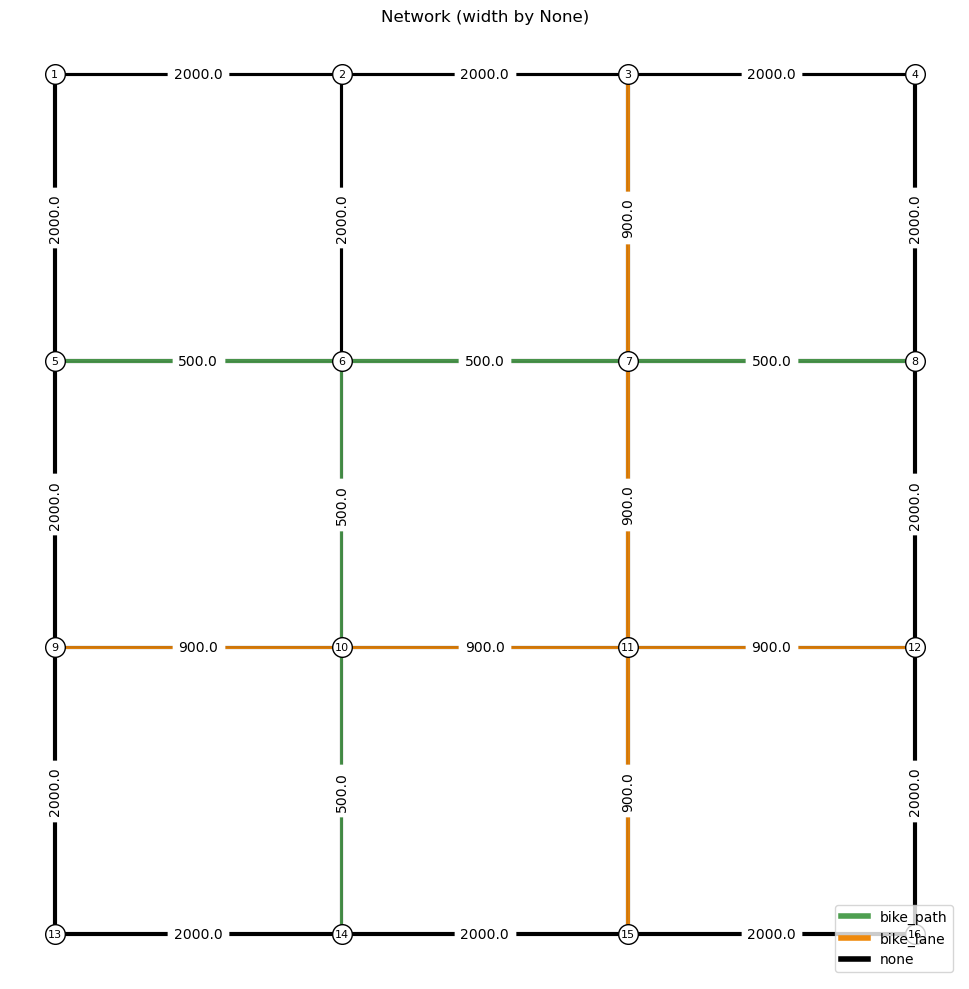

In [6]:
plot_network(edge_df, node_df, color_col_str='type_bike', base_width=0.2, width_scale=5, node_size=200, legend=True,  node_label=True, edges_label_col='length_bi')

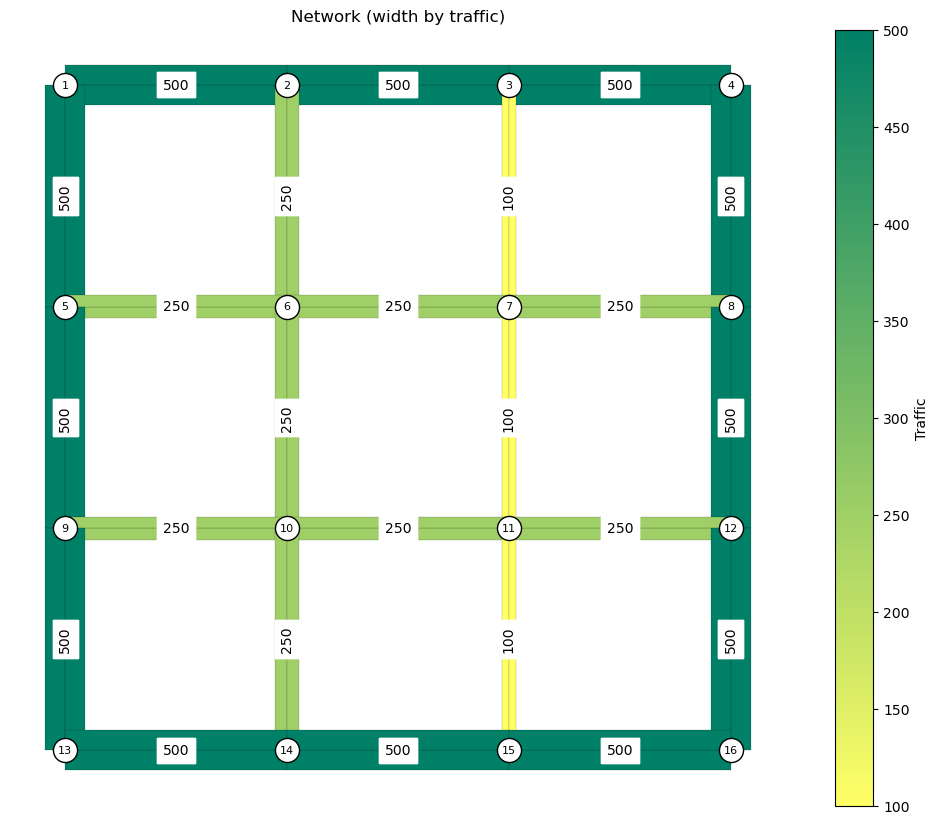

In [7]:
plot_network(edge_df, node_df, node_size=300, node_label=True, color_col_num='traffic', base_width=0.5, legend=True, width_col='traffic', width_scale=50, edges_label_col='traffic',cmap="summer_r")

In [34]:
modal_share = {'bike': 0.25, 'car': 0.75}
od_matrix = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
od_matrix.loc[1,16] = 50
od_matrix.loc[2,14]=100
od_matrix.loc[4,13]=100
od_matrix.loc[5,12]=100
od_matrix.loc[3,15]=100
od_matrix.loc[8,10]=100
od_matrix.loc[16,4]=100
od_bike = od_matrix.copy()
od_bike = od_bike*modal_share['bike']
od_car = od_matrix.copy()
od_car = od_car*modal_share['car']
od_bike = convert_to_eaquilibrae_od_matrix(od_bike)
od_car = convert_to_eaquilibrae_od_matrix(od_car)

## Models

In [9]:
bike_results_1 = ta_stochastic(
    edges_gdf=edge_df,
    od_gdf=od_bike,
    mode='bike',
    time_field='length_bi',
    cost_field='length_bi',
    algorithm='bfsle',
    max_routes=3,
    capacity_field='capacity_bikes'
)

Stochastic (bike) completed in 0.00s | TTT: 635000


In [10]:
cars_results = ta_stochastic(edge_df, od_car, mode='cars',
                  time_field='travel_time_cars', cost_field='length',
                  algorithm='bfsle', max_routes=1, 
                  capacity_field='capacity_cars')

print(f"\n--- Car Results ---")
print(f"Total Travel Time: {cars_results['total_travel_time']:,.0f} min")
print(f"Computation Time:  {cars_results['computation_time']:.2f} s")
print(f"Links with flow:   {(cars_results['flow'] > 0).sum()} out of {len(cars_results['flow'])}")
print(f"Max link flow:     {cars_results['flow'].max():,.0f}")

Stochastic (cars) completed in 0.00s | TTT: 76

--- Car Results ---
Total Travel Time: 76 min
Computation Time:  0.00 s
Links with flow:   21 out of 48
Max link flow:     225


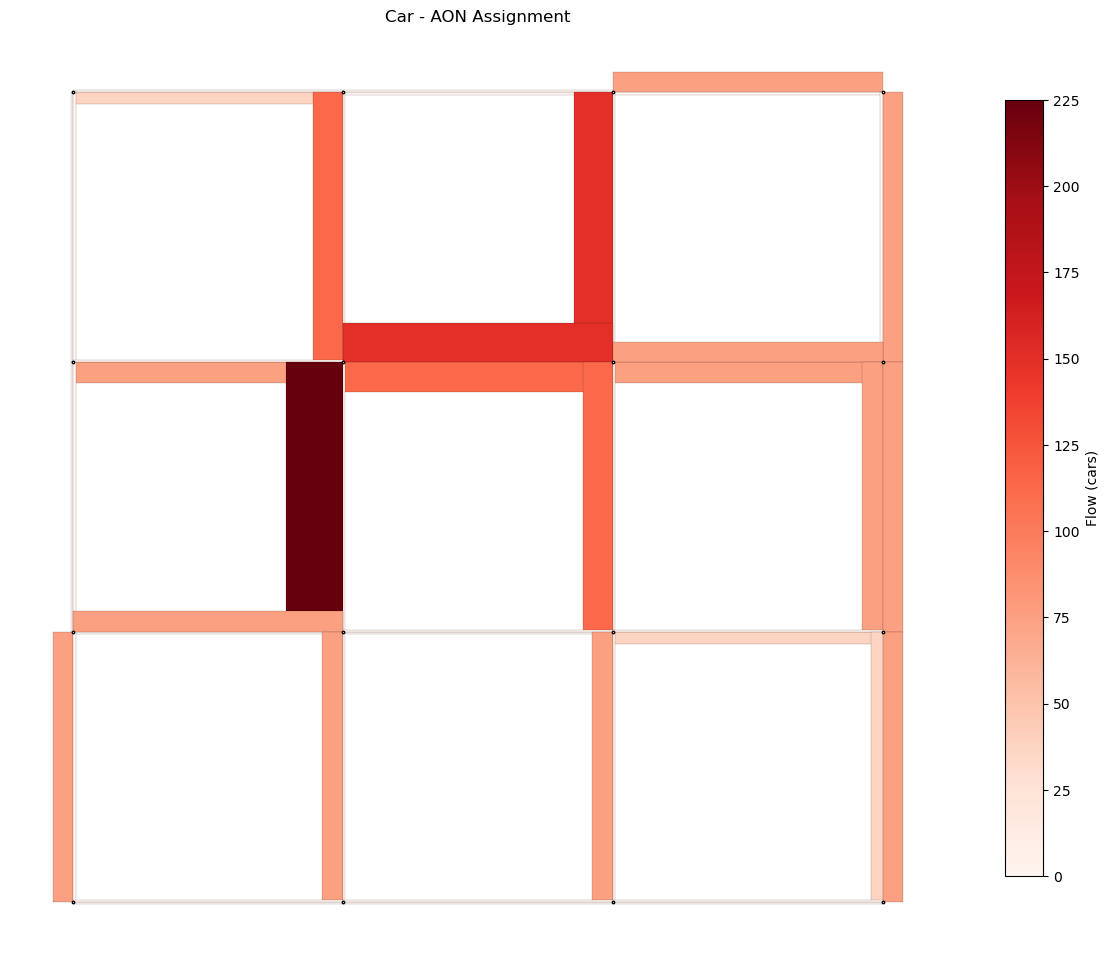

In [11]:
plot_network(
    cars_results['network'], node_df,
    width_col='flow',
    color_col_num='flow',
    cmap='Reds',
    title='Car - AON Assignment',
    figsize=(12, 10),
    node_size=3,
    colorbar_label='Flow (cars)',
    base_width=0.3,
    width_scale=300
)
edge_df["traffic"] = cars_results['network']['flow']

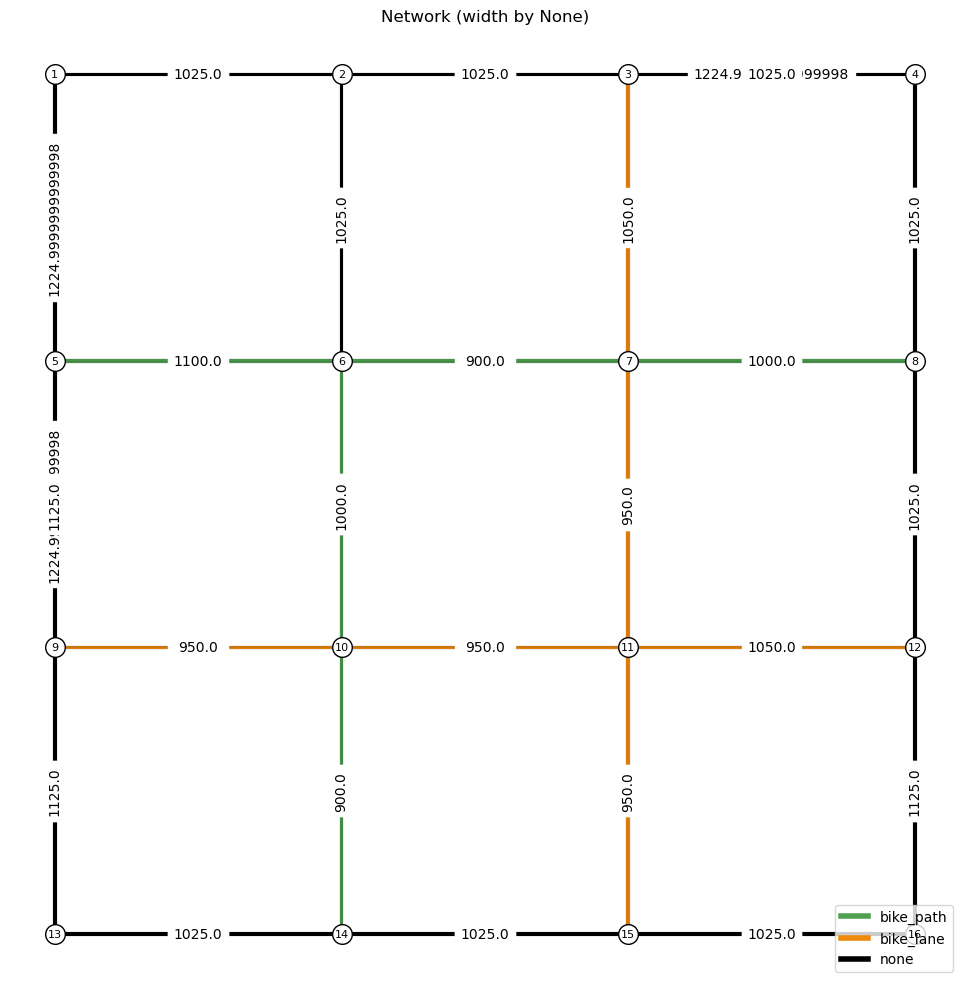

In [12]:
edge_df = simple_bi_2(edge_df)
plot_network(edge_df, node_df, color_col_str='type_bike', base_width=0.2, width_scale=5, node_size=200, legend=True,  node_label=True, edges_label_col='length_bi')

Stochastic (bikes) completed in 0.00s | TTT: 615938


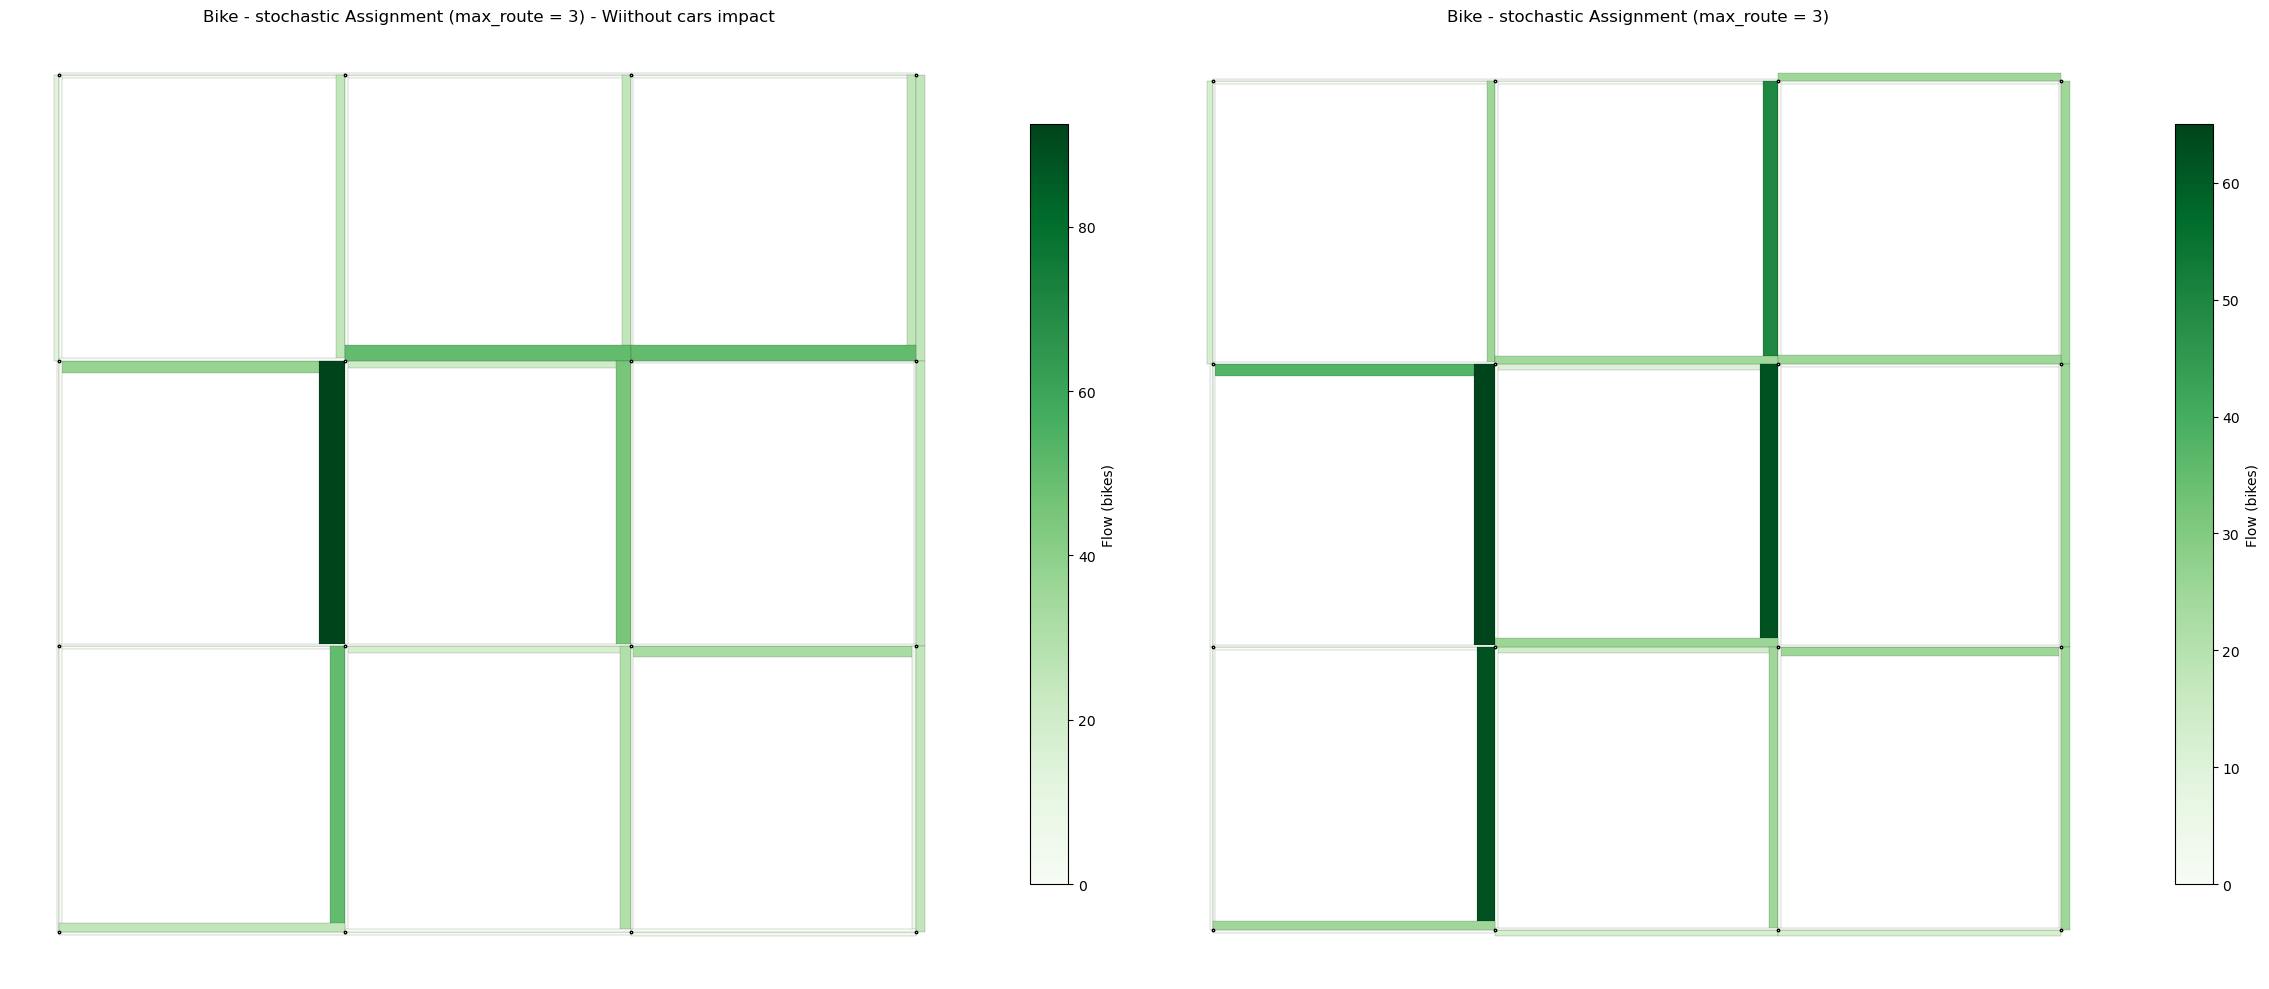

In [13]:
bike_results_2 = ta_stochastic(edge_df, od_bike, mode='bikes',
                  time_field='length_bi', cost_field='length_bi',
                  algorithm='bfsle', max_routes=3, 
                  capacity_field='capacity_bikes')

fig_comp, axes = plt.subplots(1, 2, figsize=(24, 10))

plot_network(
    bike_results_1['network'], node_df,
    width_col='flow',
    color_col_num='flow',
    cmap='Greens',
    title='Bike - stochastic Assignment (max_route = 3) - Wiithout cars impact',
    figsize=(12, 10),
    node_size=3,
    colorbar_label='Flow (bikes)',
    base_width=0.3,
    width_scale=300,
    ax=axes[0]
)

plot_network(
    bike_results_2['network'], node_df,
    width_col='flow',
    color_col_num='flow',
    cmap='Greens',
    title='Bike - stochastic Assignment (max_route = 3)',
    figsize=(12, 10),
    node_size=3,
    colorbar_label='Flow (bikes)',
    base_width=0.3,
    width_scale=300,
    ax=axes[1],
    vmax=65
)

# tests of impact of bl removal

Stochastic (cars) completed in 0.00s | TTT: 76
Stochastic (cars) completed in 0.00s | TTT: 76
Stochastic (bikes) completed in 0.00s | TTT: 615938
Stochastic (bikes) completed in 0.00s | TTT: 620000


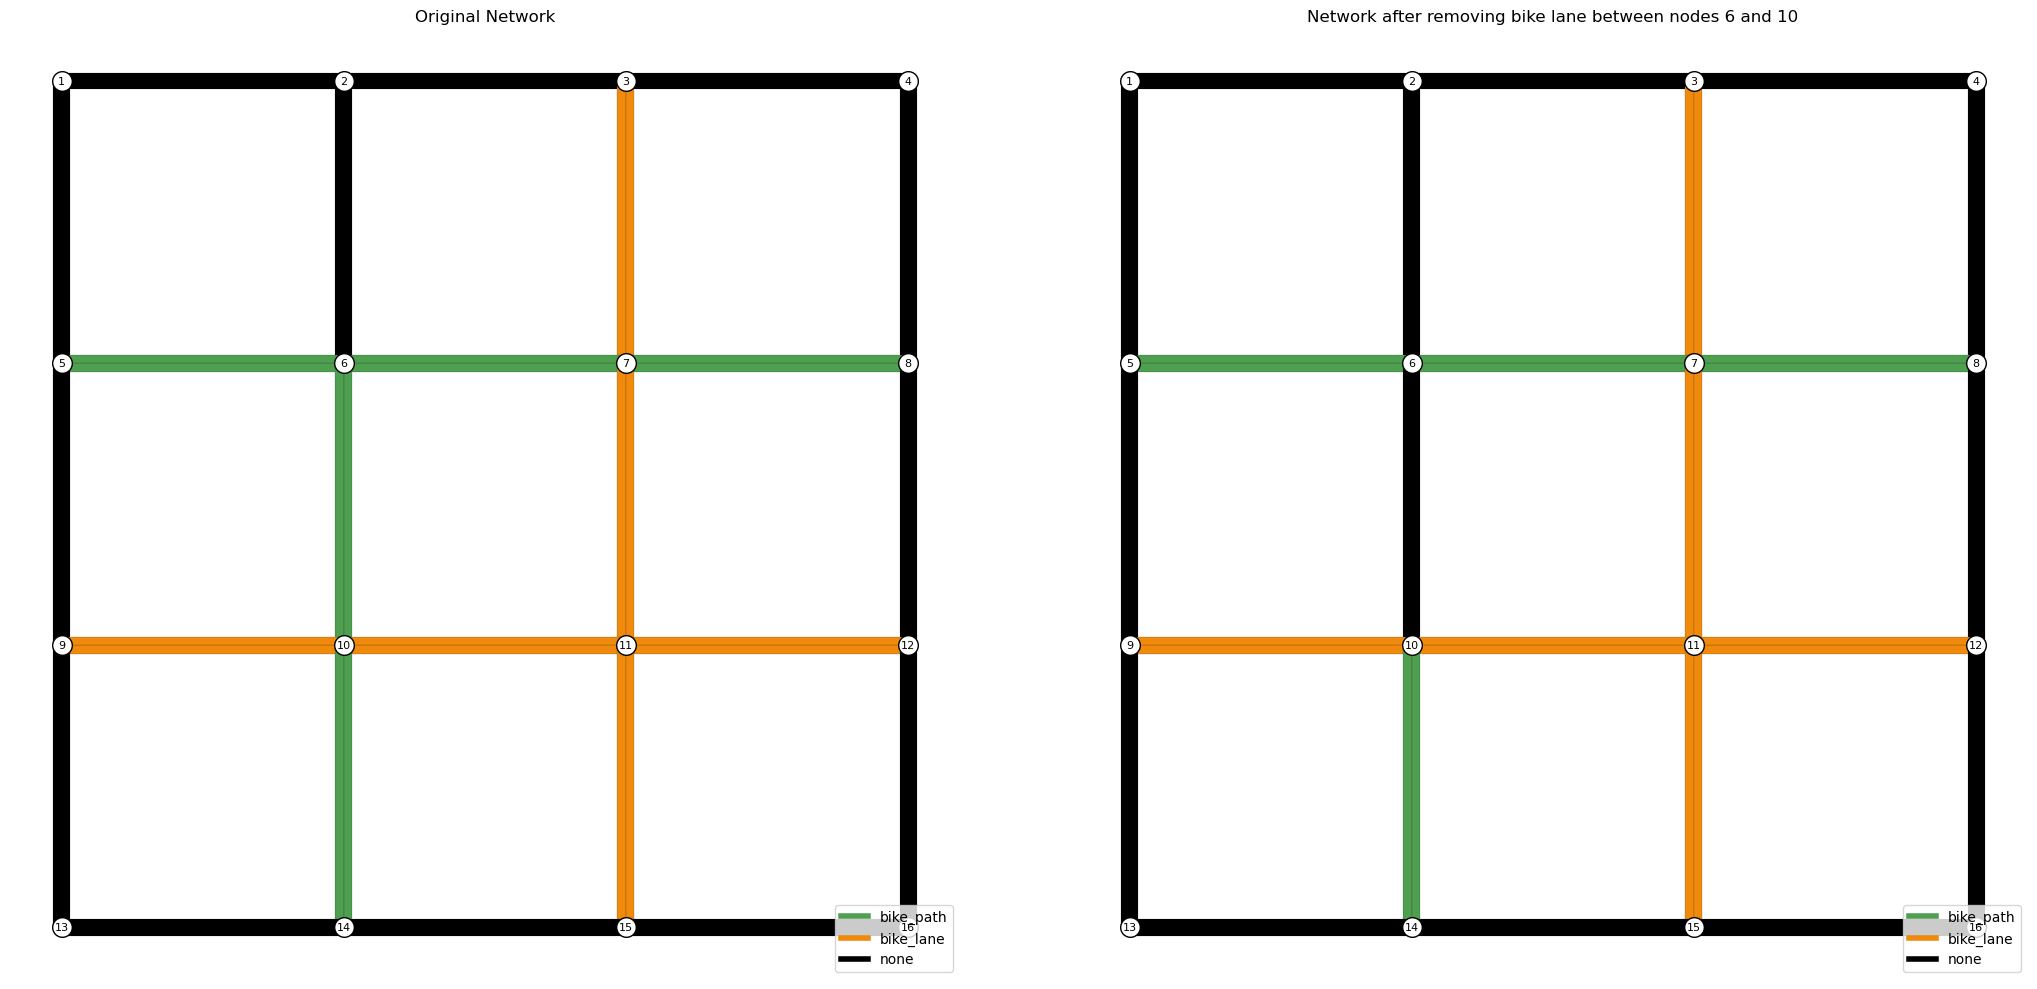

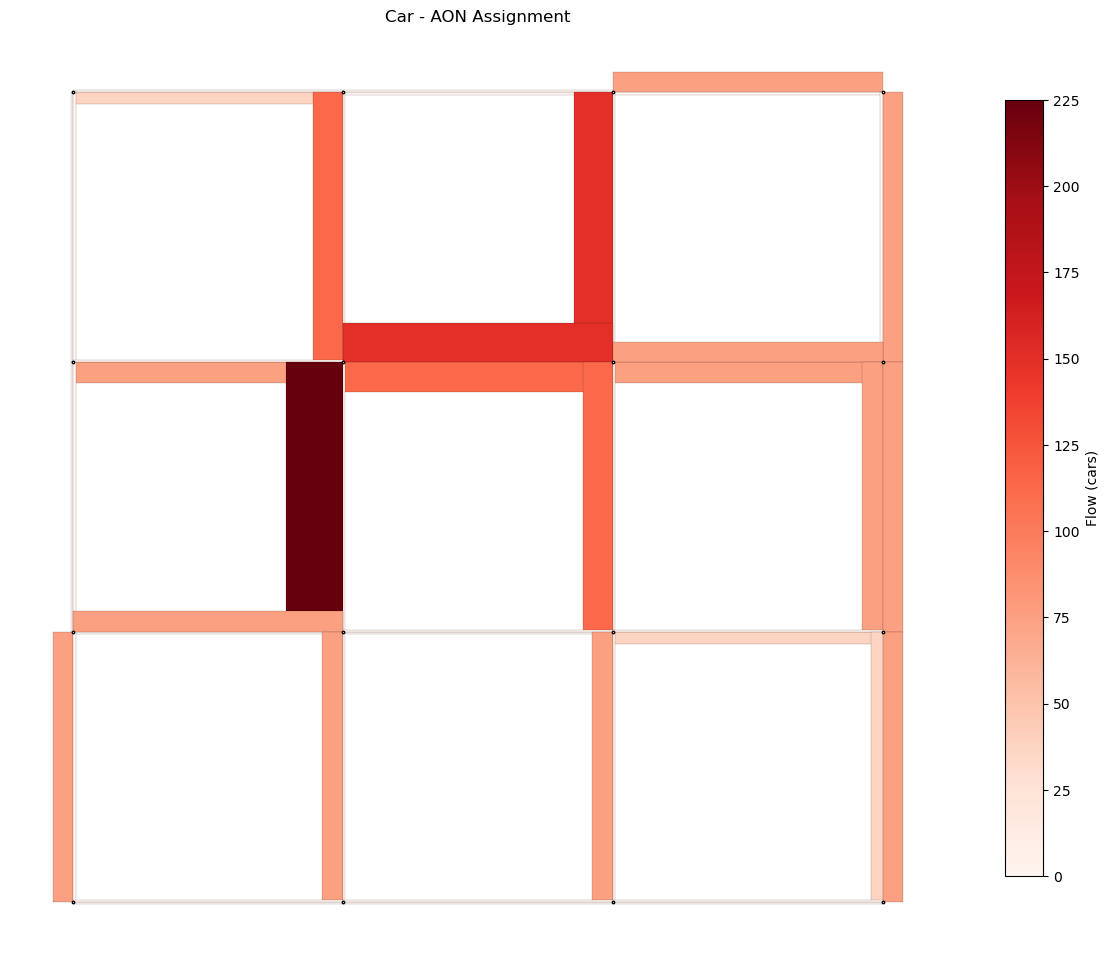

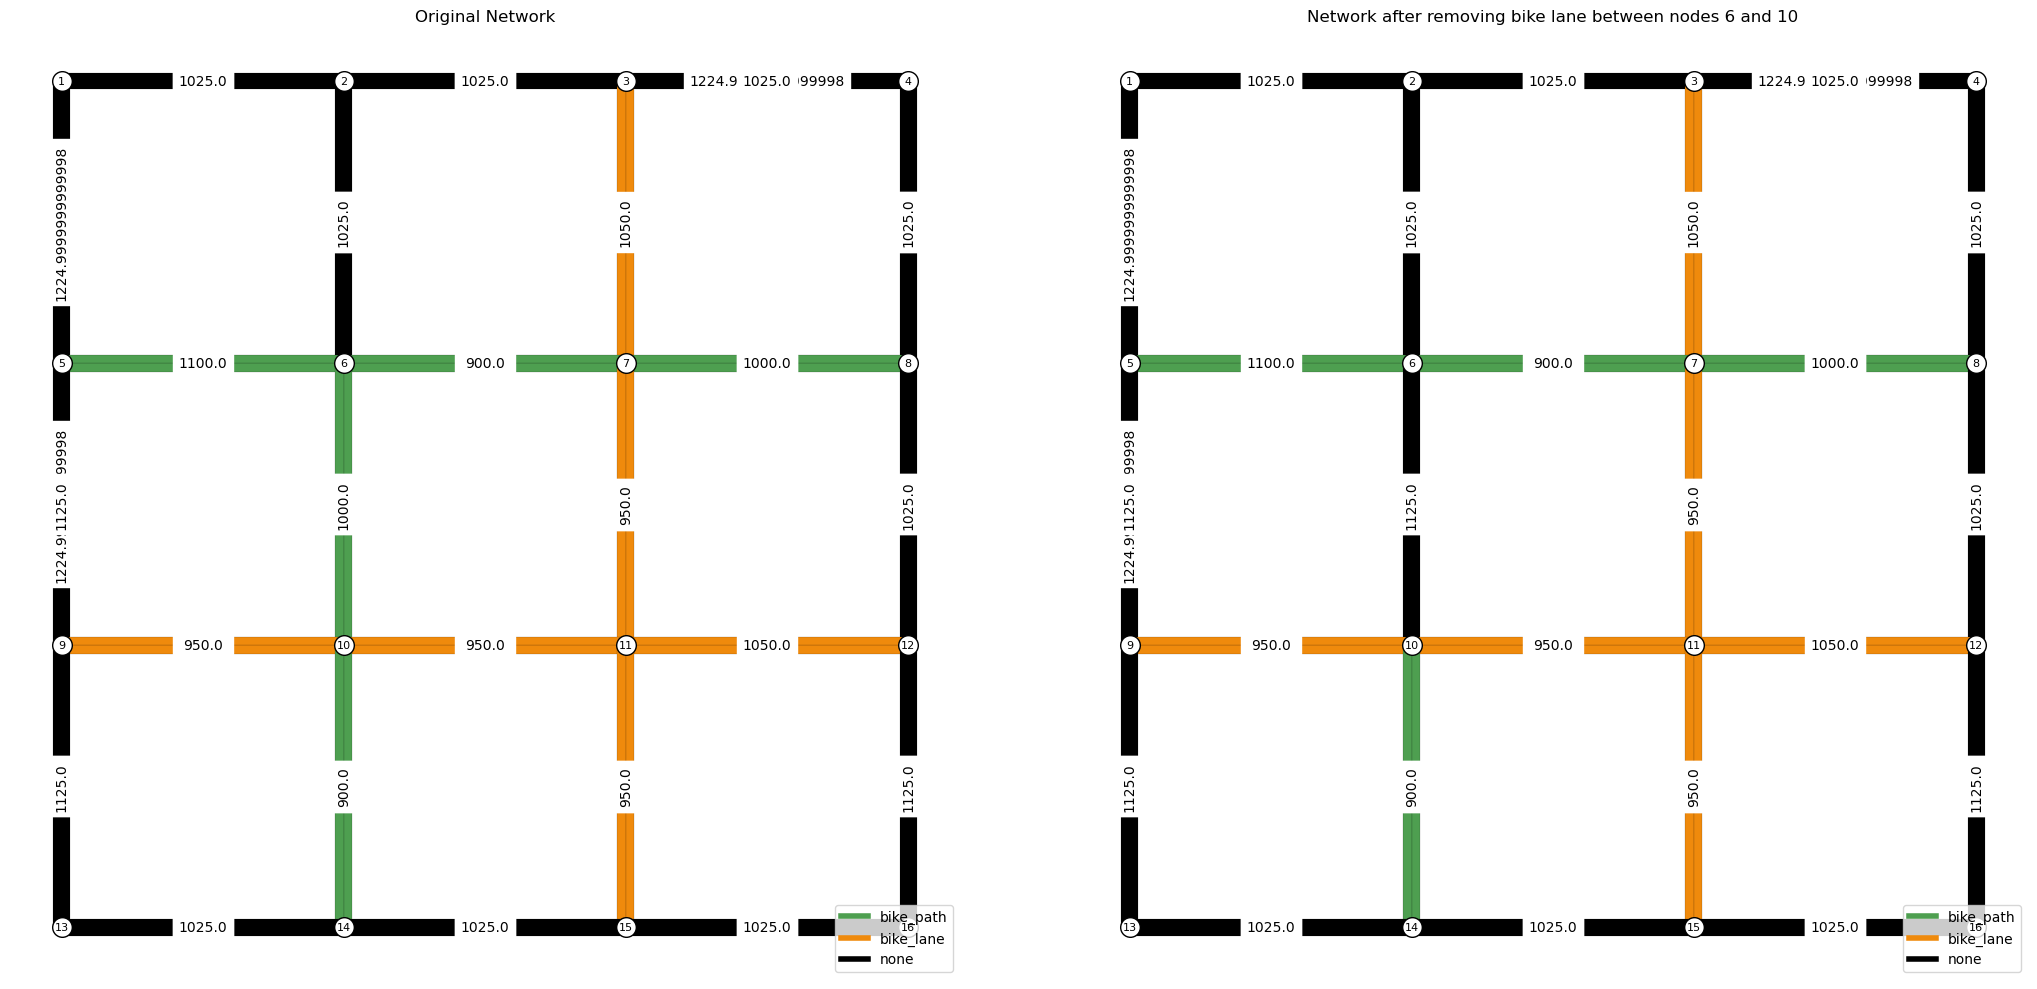

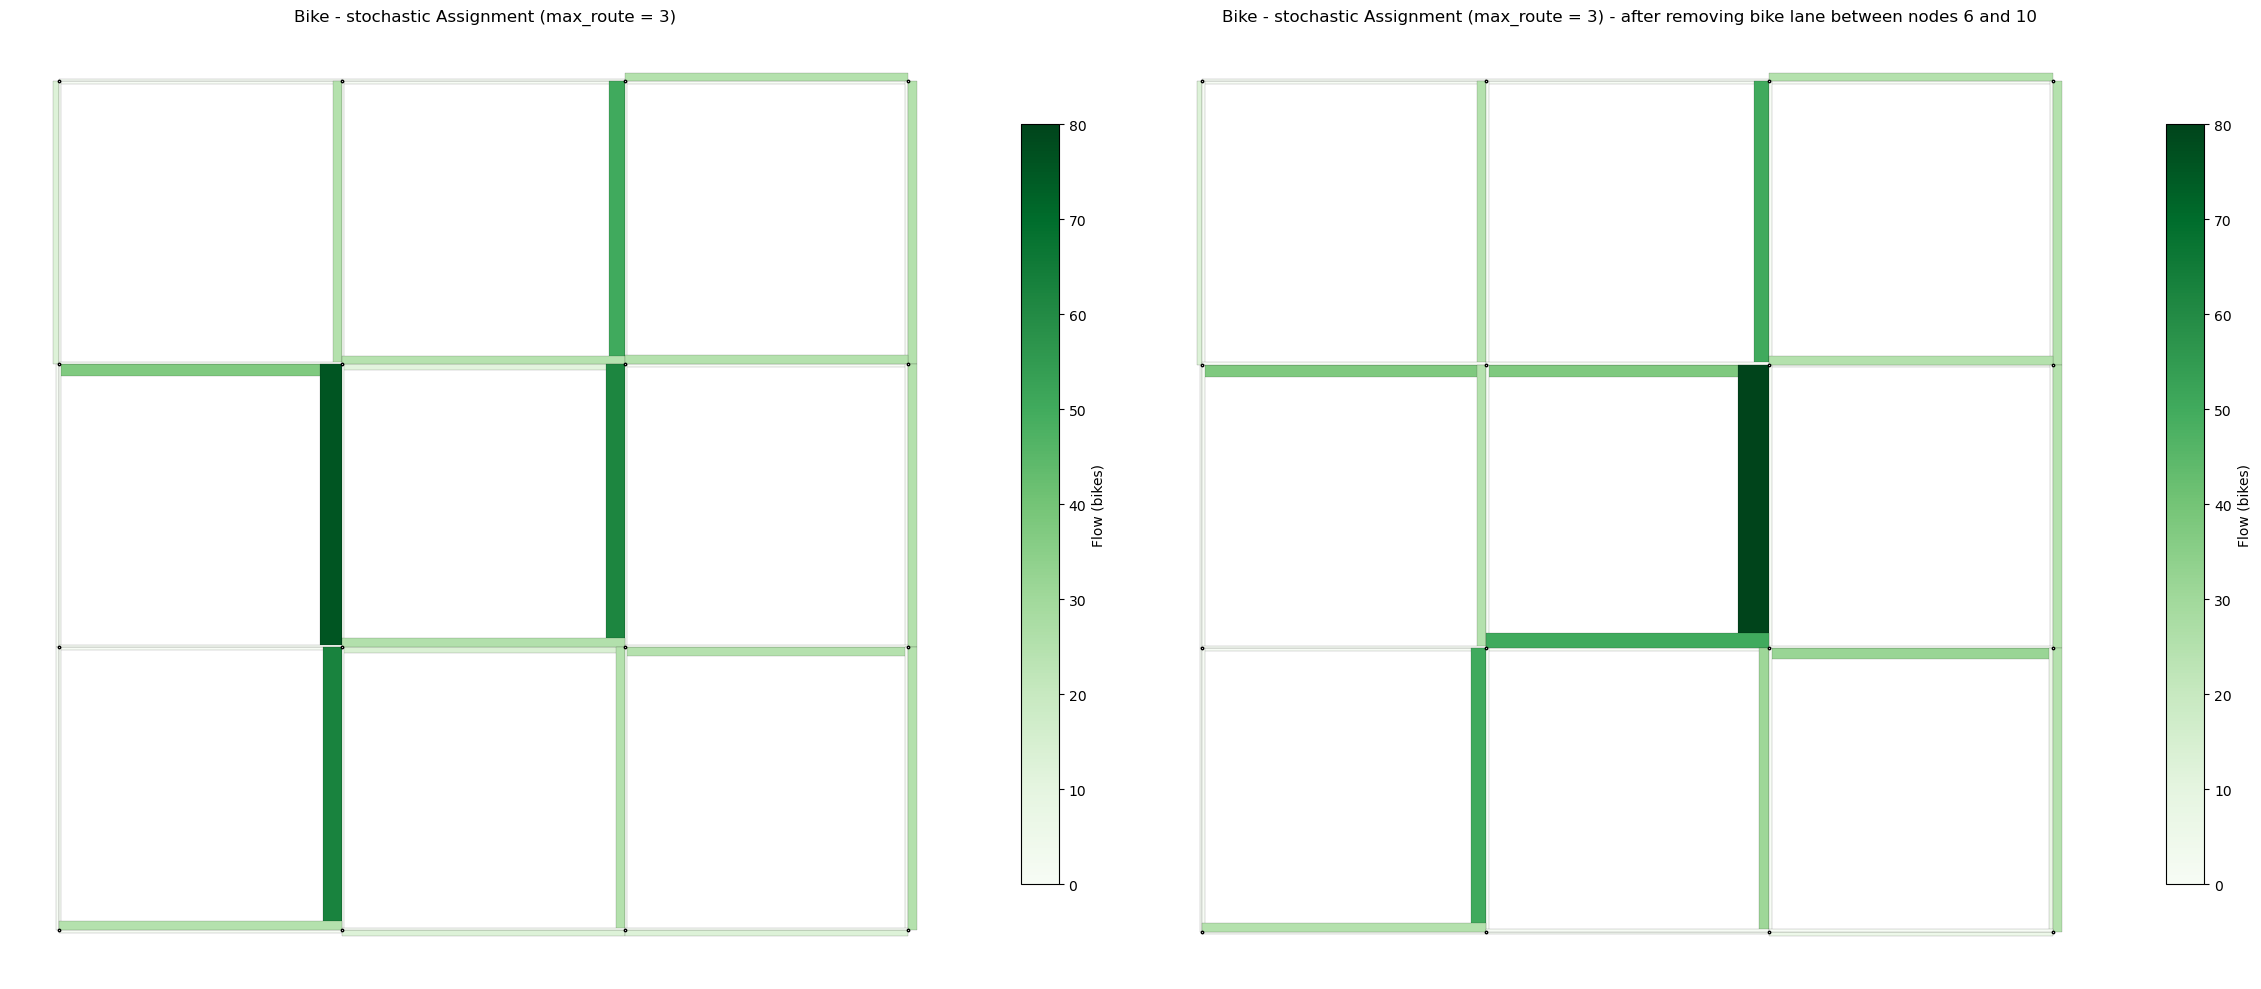

In [19]:
#import
edge_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/edges_small_grid_2.csv")
node_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/nodes_small_grid_2.csv")

edge_df = set_capacity_bikes(edge_df, capacity_per_lane=200) #manual assigment of slope, gb coverage, lane capacity
edge_df = set_capacity_cars(edge_df, capacity_per_lane=1000)
edge_df = time_estimation_cars(edge_df)
edge_df['slope']=1 
edge_df['green_blue_coverage']=0.7

#create modified network
edge_df_2 = change_type_bike(edge_df,6,10,None)
edge_df_2 = change_type_bike(edge_df_2,10,6,None)
fig, axes = plt.subplots(1,2, figsize=(24,10))
plot_network(edge_df, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True, ax=axes[0], title='Original Network')
plot_network(edge_df_2, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True, ax=axes[1], title='Network after removing bike lane between nodes 6 and 10')

#cars traffic assigment
cars_results_base_network = ta_stochastic(edge_df, od_car, mode='cars',
                  time_field='travel_time_cars', cost_field='length',
                  algorithm='bfsle', max_routes=1, 
                  capacity_field='capacity_cars')

cars_results_modified_network = ta_stochastic(edge_df_2, od_car, mode='cars',
                  time_field='travel_time_cars', cost_field='length',
                  algorithm='bfsle', max_routes=1, 
                  capacity_field='capacity_cars')
edge_df['traffic'] = cars_results_base_network['network']['flow']
edge_df_2['traffic'] = cars_results_modified_network['network']['flow']
plot_network(
    cars_results_base_network['network'], node_df,
    width_col='flow',
    color_col_num='flow',
    cmap='Reds',
    title='Car - AON Assignment',
    figsize=(12, 10),
    node_size=3,
    colorbar_label='Flow (cars)',
    base_width=0.3,
    width_scale=300
)
#calcul of BI
edge_df = simple_bi_2(edge_df)
edge_df_2 = simple_bi_2(edge_df_2)
fig, axes = plt.subplots(1,2, figsize=(24,10))
plot_network(edge_df_2, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True, edges_label_col='length_bi', ax=axes[1], title='Network after removing bike lane between nodes 6 and 10')
plot_network(edge_df, node_df, ax=axes[0],color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True, edges_label_col='length_bi', title='Original Network')

#bike traffic assigment
bike_results_base_network = ta_stochastic(edge_df, od_bike, mode='bikes',
                  time_field='length_bi', cost_field='length_bi',
                  algorithm='bfsle', max_routes=3, 
                  capacity_field='capacity_bikes')

bike_results_modified_network = ta_stochastic(edge_df_2, od_bike, mode='bikes',
                  time_field='length_bi', cost_field='length_bi',
                  algorithm='bfsle', max_routes=3, 
                  capacity_field='capacity_bikes')

fig_comp, axes = plt.subplots(1, 2, figsize=(24, 10))
plot_network(
    bike_results_base_network['network'], node_df,
    width_col='flow',
    color_col_num='flow',
    cmap='Greens',
    title='Bike - stochastic Assignment (max_route = 3)',
    figsize=(12, 10),
    node_size=3,
    colorbar_label='Flow (bikes)',
    base_width=0.3,
    width_scale=300,
    ax=axes[0],
    vmax=80
)

plot_network(
    bike_results_modified_network['network'], node_df,
    width_col='flow',
    color_col_num='flow',
    cmap='Greens',
    title='Bike - stochastic Assignment (max_route = 3) - after removing bike lane between nodes 6 and 10',
    figsize=(12, 10),
    node_size=3,
    colorbar_label='Flow (bikes)',
    base_width=0.3,
    width_scale=300,
    ax=axes[1],
    vmax=80
)

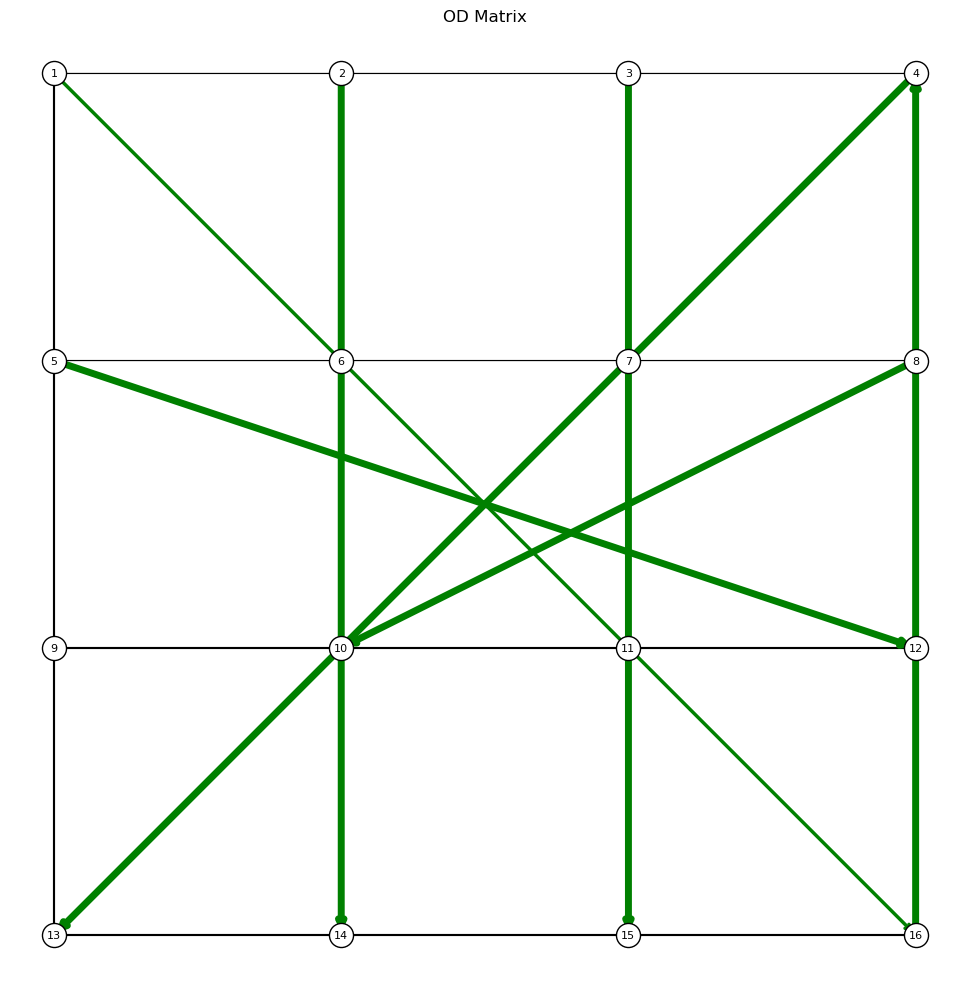

In [15]:
plot_od_matrix(od_bike, edge_df, node_df, label=False, color='green')

# test full optimisation framework

### Init

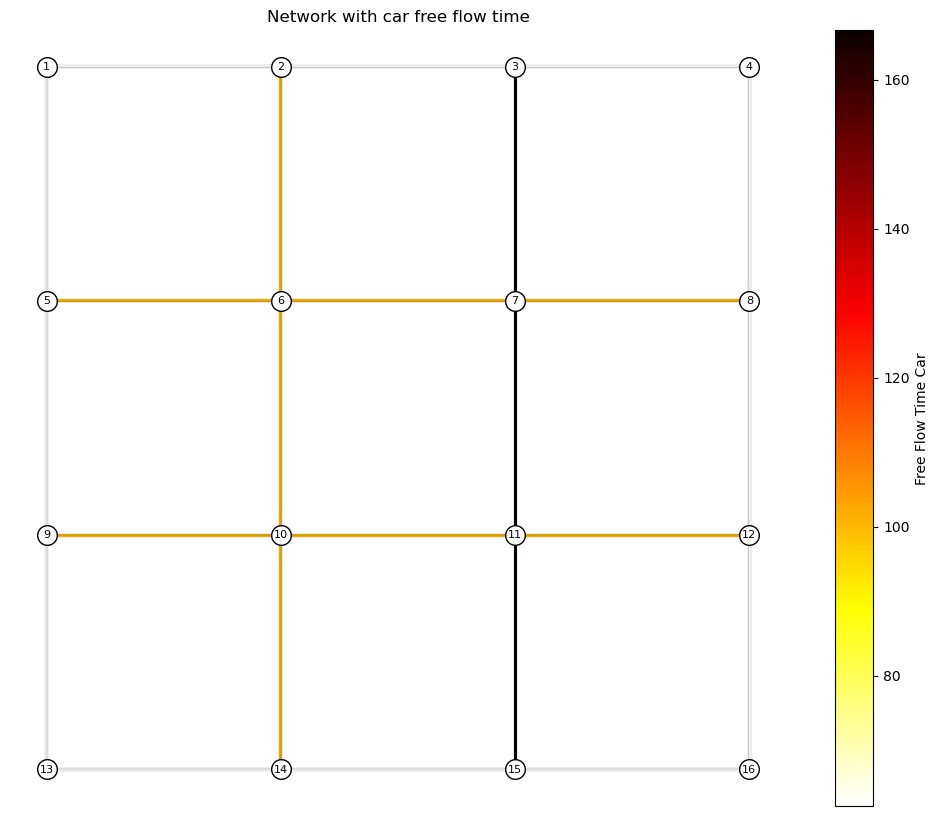

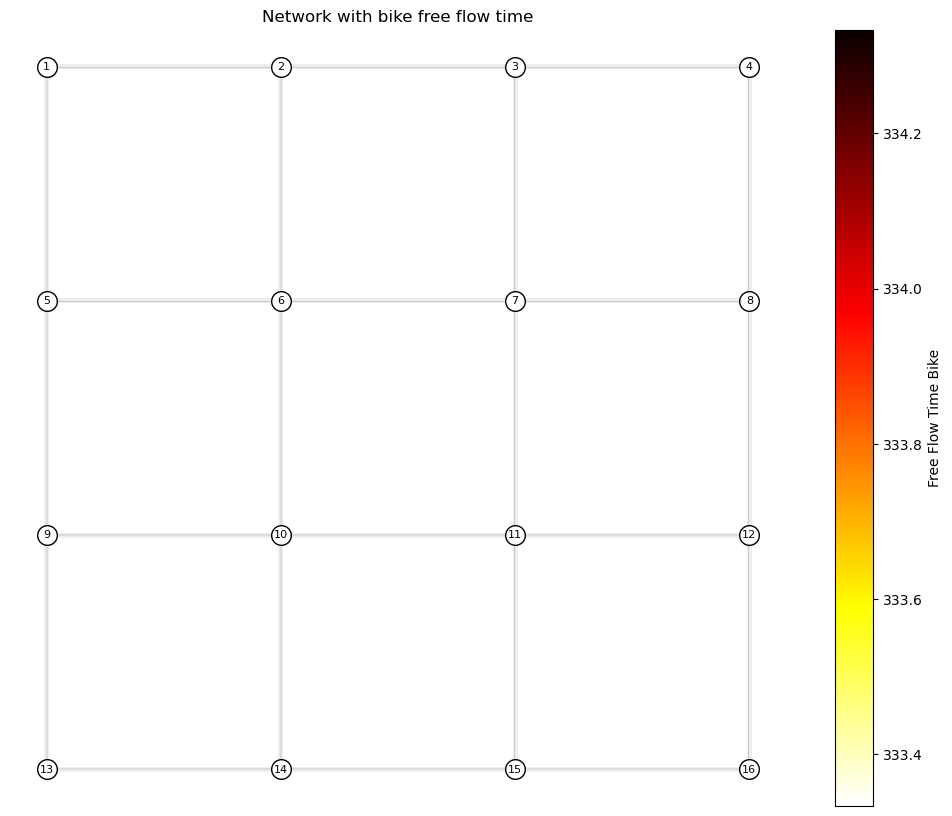

In [179]:
#import
edge_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/edges_small_grid_2.csv")
node_df = pd.read_csv("/Users/tristan.lemoalle/Documents/Thèse/Code/code_these/config/nodes_small_grid_2.csv")

edge_df = set_capacity_bikes(edge_df, capacity_per_lane=200) #manual assigment of slope, gb coverage, lane capacity
edge_df = set_capacity_cars(edge_df, capacity_per_lane=1000)
#edge_df = time_estimation_cars(edge_df)

edge_df = free_flow_time(edge_df, 'car')
edge_df = free_flow_time(edge_df, 'bike')
edge_df["travel_time_car"] = edge_df['free_flow_time_car']
edge_df["travel_time_bike"] = edge_df['free_flow_time_bike']
edge_df['length'] = edge_df['length'].apply(lambda x: np.float64(x))
edge_df['slope']=1 
edge_df['green_blue_coverage']=0.7
edge_df_modif = edge_df.copy()
for edge in edge_df.itertuples():
    edge_df_modif = change_type_bike(edge_df_modif, edge.a_node, edge.b_node, 'bike_path')
#edge_df_modif = edge_df_modif.drop(columns="length_bi")
plot_network(edge_df, node_df, color_col_num='free_flow_time_car', base_width=0.2, width_scale=5, node_size=200, legend=True,  node_label=True,title='Network with car free flow time', cmap="hot_r")
plot_network(edge_df_modif, node_df, color_col_num='free_flow_time_bike', base_width=0.2, width_scale=5, node_size=200, legend=True,  node_label=True,title='Network with bike free flow time', cmap="hot_r")

### OD MATRIX

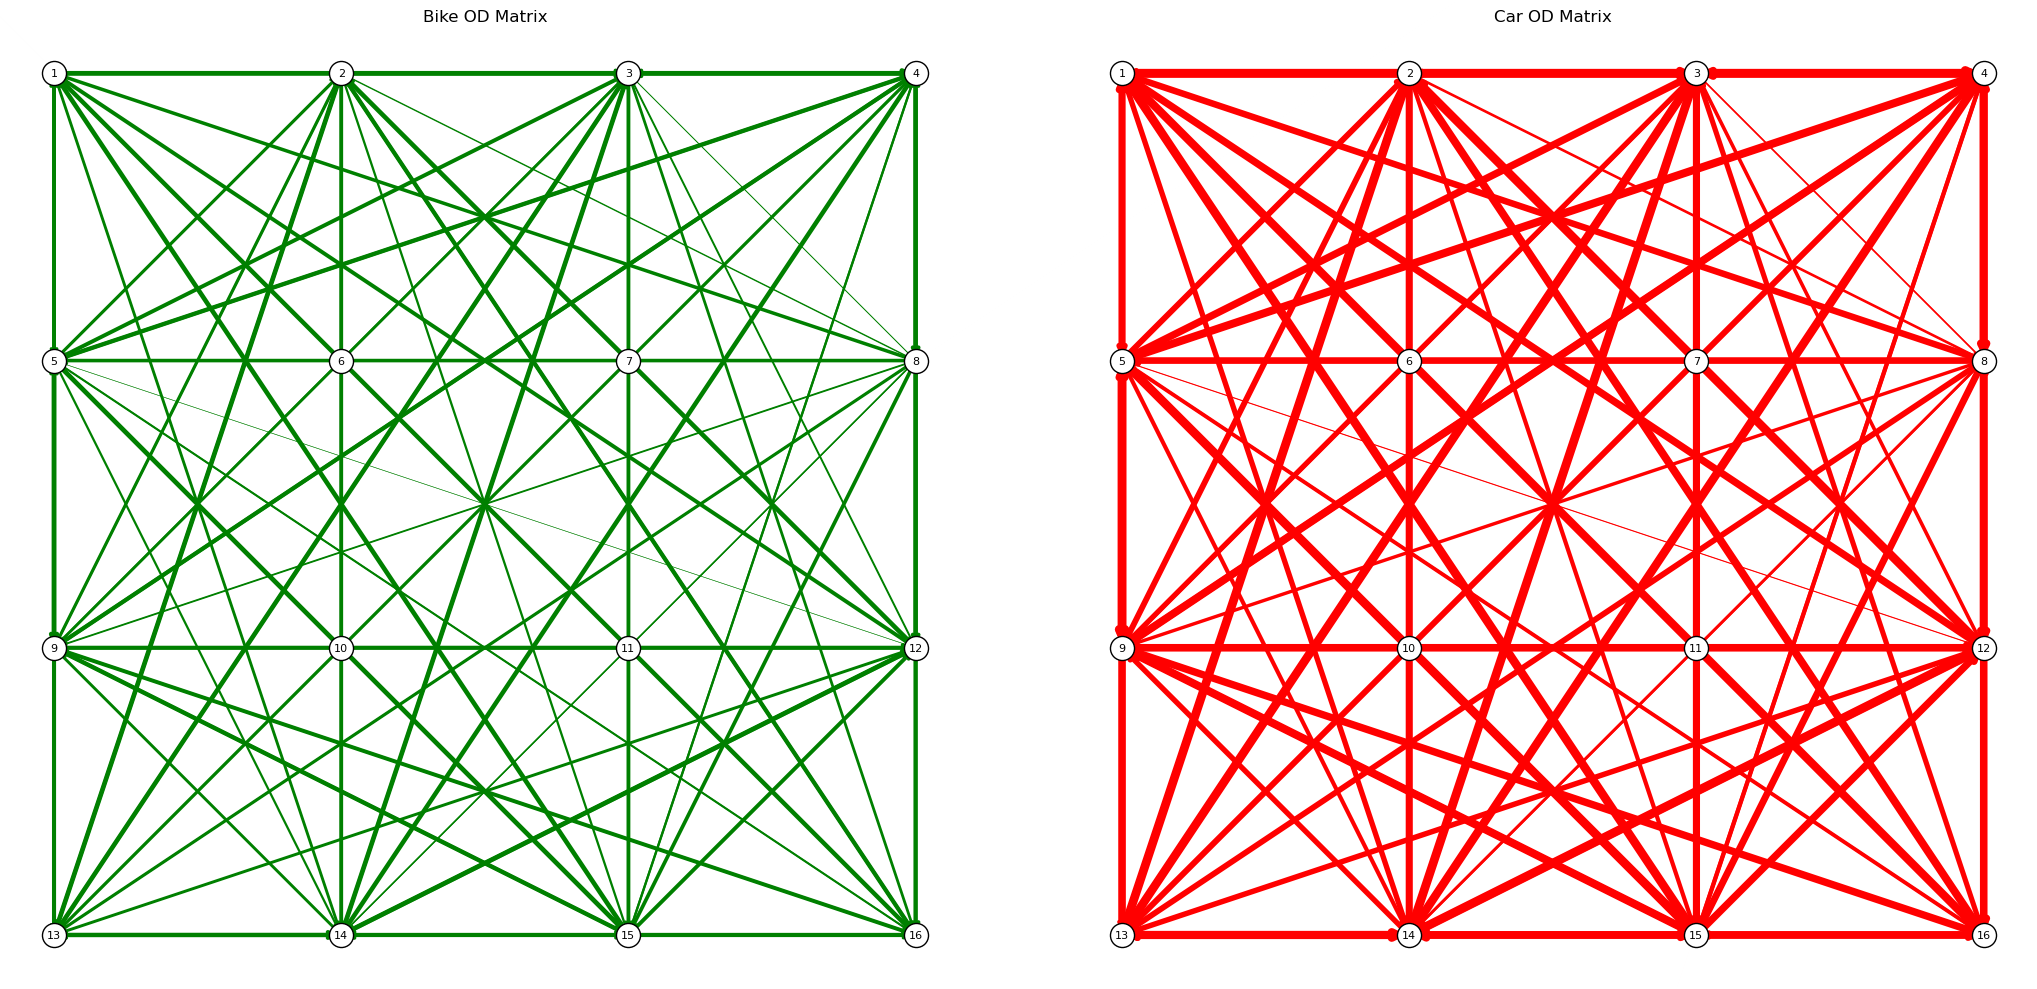

In [176]:
# Base OD matrix
np.random.seed(69)
od_matrix = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
liste_i = [1,2,3,4,5,9,13,15,14,16,12,8]
for i in liste_i:
    for j in liste_i:
        if i != j:
            od_matrix.loc[i,j] = np.random.randint(30,1000)
modal_share = {'bike': 0.35, 'car': 0.65}
od_bike = od_matrix.copy()
od_bike = od_bike*modal_share['bike']
od_car = od_matrix.copy()
od_car = od_car*modal_share['car']
od_bike = convert_to_eaquilibrae_od_matrix(od_bike)
od_car = convert_to_eaquilibrae_od_matrix(od_car)
fig, axes = plt.subplots(1,2, figsize=(24,10))
plot_od_matrix(od_bike, edge_df_modif, node_df, label=False, title='Bike OD Matrix', color='green',ax=axes[0], vmax=500)
plot_od_matrix(od_car, edge_df_modif, node_df, label=False, title='Car OD Matrix', color='red', ax=axes[1], vmax=500)

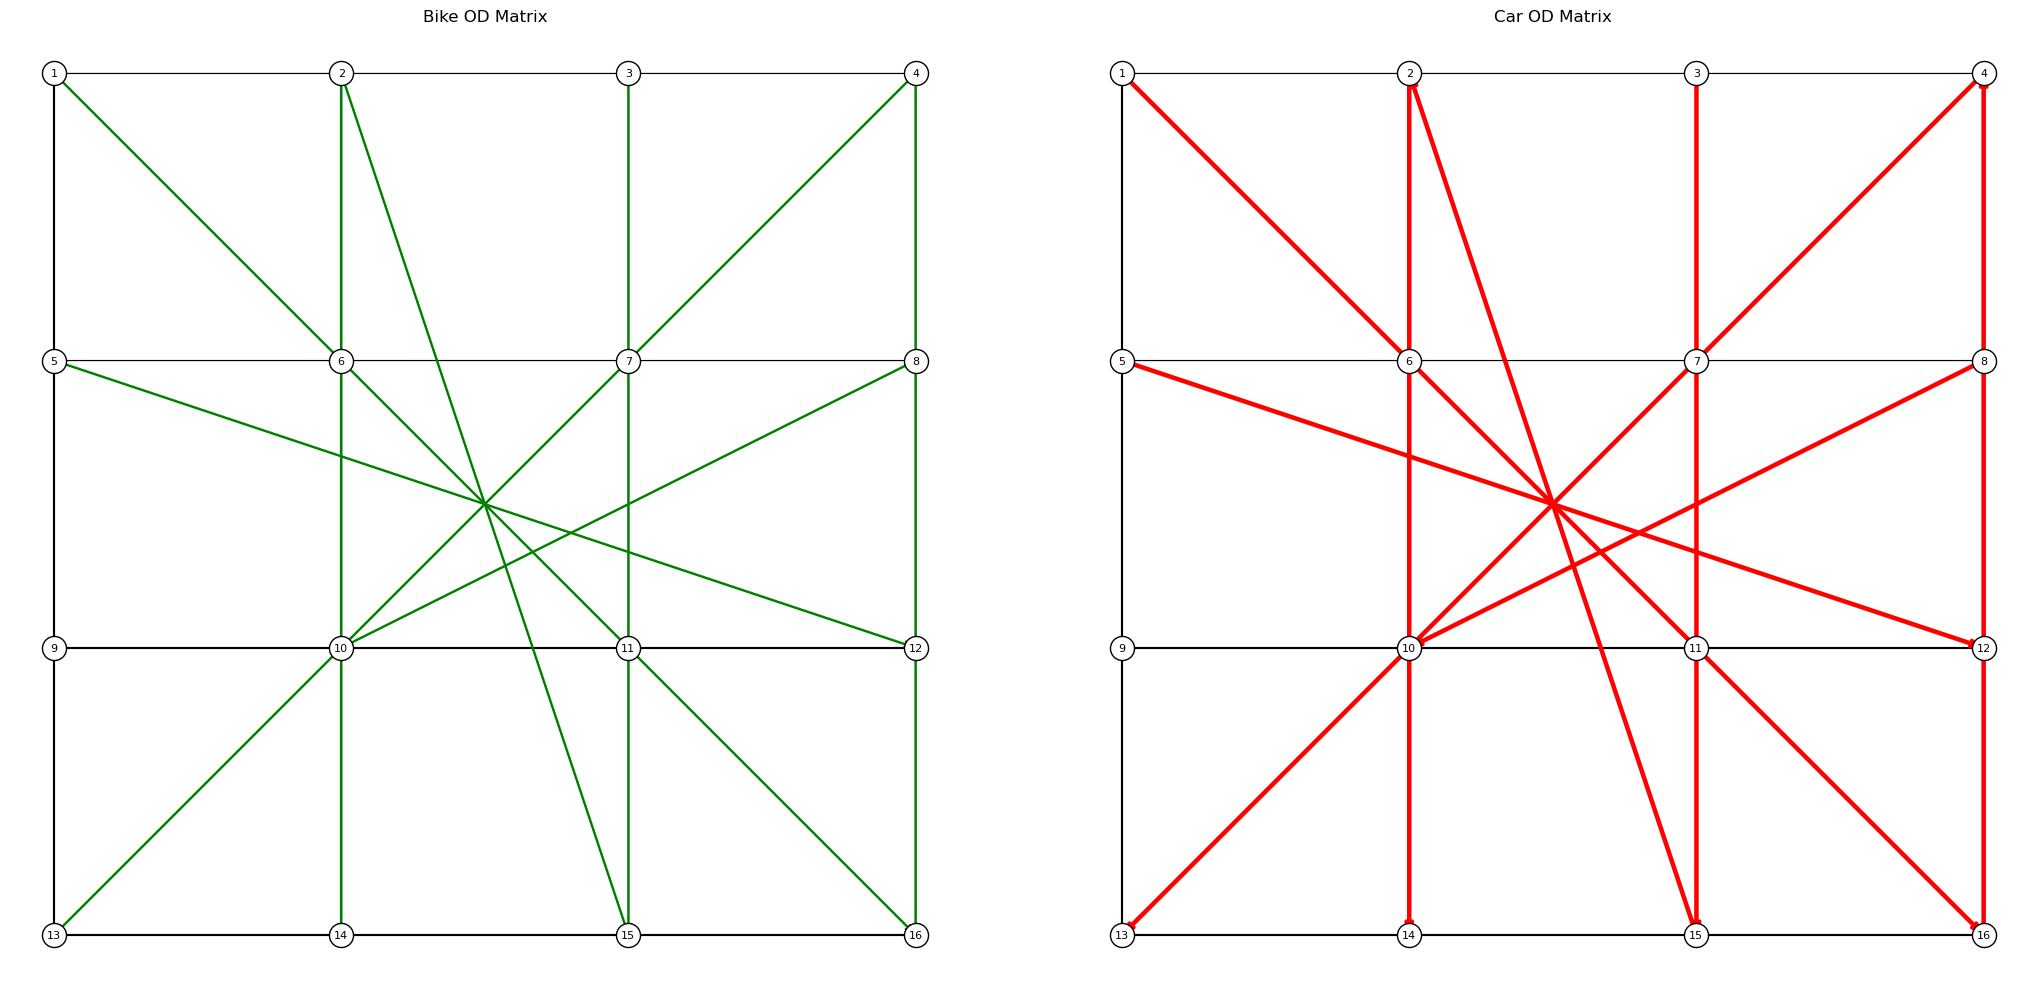

In [ ]:
#manual OD matrix
modal_share = {'bike': 0.35, 'car': 0.65}
od_matrix = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
od_matrix.loc[1,16] = 100
od_matrix.loc[2,14] = 100
od_matrix.loc[4,13] = 100
od_matrix.loc[15,2] = 100
od_matrix.loc[5,12] = 100
od_matrix.loc[3,15] = 100
od_matrix.loc[8,10] = 100
od_matrix.loc[16,4] = 100
od_bike = od_matrix.copy()
od_bike = od_bike*modal_share['bike']
od_car = od_matrix.copy()
od_car = od_car*modal_share['car']
od_bike = convert_to_eaquilibrae_od_matrix(od_bike)
od_car = convert_to_eaquilibrae_od_matrix(od_car)
fig, axes = plt.subplots(1,2, figsize=(24,10))
plot_od_matrix(od_bike, edge_df_modif, node_df, label=False, title='Bike OD Matrix', color='green',ax=axes[0], vmax=100)
plot_od_matrix(od_car, edge_df_modif, node_df, label=False, title='Car OD Matrix', color='red', ax=axes[1], vmax=100)

### LOOP

In [ ]:
edge_df_tri=edge_df_modif.copy().reset_index(drop=True)
nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
len_df = 30
i = 0
limit = 100
beta = 5
results_df = pd.DataFrame()
nbr_bike_lanes = edge_df_modif['type_bike'].notnull().sum()
nbr_none_bike_lanes = edge_df_modif['type_bike'].isnull().sum()
results_df = pd.concat([results_df, pd.DataFrame({'iteration': [0],
                                    'nbr_bike_lanes': nbr_bike_lanes,
                                    'nbr_none_bike_lanes': nbr_none_bike_lanes})], ignore_index=True)
plot = False
plot_network(edge_df_tri, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True,title=f'Initial network', figsize=(5,5), edges_label_col='index')
plt.show()

while nbr_bike_lanes > 0 and i < limit :
    i += 1
    print(f"\n--- Iteration {i} ---")
    print("➡️ Running traffic assignments...")
    print("➡️ Cars assignment...")
    
    name_col_flow_car = 'flow_car_iteration_'+str(i)
    name_col_flow_bike = 'flow_bike_iteration_'+str(i)

    # run car traffic assignment
    cars_results = ta_stochastic(edge_df_tri, od_car, mode='cars',
                  time_field='travel_time_cars', cost_field='length',
                  algorithm='bfsle', max_routes=1,
                  capacity_field='capacity_cars')
    edge_df_tri = cars_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_car})

    print("✅ Cars assignment done.")
    print("➡️ Bikes assignment...")

    #recalculate bike infrastructure
    edge_df_tri = simple_bi_2(edge_df_tri, traffic_col='flow_car_iteration_1')

    #run bike traffic assignment
    bike_results = ta_stochastic(
                                edge_df_tri, 
                                od_bike, 
                                mode='bikes',
                                time_field='length_bi', 
                                cost_field='length_bi',
                                algorithm='bfsle', 
                                max_routes=3,
                                capacity_field='capacity_bikes',
                                beta=beta
                                )
    
    edge_df_tri = bike_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_bike})

    print("✅ Bikes assignment done.")
    print("Traffic assignments completed.")

    if plot:
        fig,axes = plt.subplots(1,2, figsize=(12,5))
        #plot car flow
        plot_network(
                    cars_results['network'], node_df,
                    width_col='flow',
                    color_col_num='flow',
                    cmap='Reds',
                    title=f'Car - AON Assignment - Iteration {i}',
                    figsize=(12, 10),
                    node_size=3,
                    colorbar_label='Flow (cars)',
                    base_width=0.3,
                    width_scale=300,
                    ax=axes[0]
                    )
        #plot bike flow
        plot_network(
                    bike_results['network'], node_df,
                    width_col='flow',
                    color_col_num='flow',
                    cmap='Greens',
                    title=f'Bike - stochastic Assignment (max_route = 3) - Iteration {i}',
                    figsize=(12, 10),
                    node_size=3,
                    colorbar_label='Flow (bikes)',
                    base_width=0.3,
                    width_scale=300,
                    ax=axes[1],
                    vmax=80
                    )
        plt.show()

    #identify edges considered for removal
    edges_considered_for_removal = edge_df_tri[edge_df_tri['type_bike'].notna()]
    indexes_removed = pd.Index([])
    #select index of least used edge
    index_least_used = edges_considered_for_removal[name_col_flow_bike].sort_values(ascending=True).index[0]
    indexes_removed = indexes_removed.union(pd.Index([index_least_used]))
    #remove infrastructures from selected edges
    edge_df_tri.loc[indexes_removed, 'type_bike'] = None

    print(f"Iteration {i} - Removing bike lane on edge {indexes_removed} with flow {edge_df_tri.loc[index_least_used, name_col_flow_bike]}")
   
    nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
    nbr_none_bike_lanes = edge_df_tri['type_bike'].isnull().sum()
    flow_of_removed_edge = edge_df_tri.loc[index_least_used, name_col_flow_bike]
    results_df = pd.concat([results_df, 
                            pd.DataFrame({'iteration': [i+1],'nbr_bike_lanes': nbr_bike_lanes,'nbr_none_bike_lanes': nbr_none_bike_lanes,'index_removed': [indexes_removed],'flow_of_removed_edge': [flow_of_removed_edge]})
                            ], ignore_index=True)
    if plot :
        plot_network(
                    edge_df_tri,
                    node_df,
                    color_col_str='type_bike',
                    base_width=1,
                    width_scale=5,
                    node_size=200,
                    legend=True, 
                    node_label=True,
                    title=f'Iteration {i} - Modified Network',
                    figsize=(5,5),
                    edges_label_col='index'
                    )
        plt.show()
        fig, axes = plt.subplots(1,2, figsize=(16,5))
        results_df.plot.line(x='iteration', y=['nbr_bike_lanes','nbr_none_bike_lanes'], figsize=(8,5), title='Evolution of number of bike lanes', ax=axes[0])
        results_df.plot.line(x='iteration', y='flow_of_removed_edge', figsize=(8,5), title='Flow of removed bike lane', ax=axes[1])
        plt.show()


#### Base Loop

- travel time based on free flow time (for both cars and bike)
- Very basic BI (impact of cars traffic only)
- One edge removed per loops

In [180]:
edge_df_tri=edge_df_modif.copy().reset_index(drop=True)
nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
i = 0
limit = 100
beta = 1
cutoff_prob = 0.0
speed_car = 25
edge_df_tri["speed_car"] = speed_car if type(speed_car) in [int, float] else edge_df_tri["speed_car"]
edge_df_tri = free_flow_time(edge_df_tri, 'car')
edge_df_tri = free_flow_time(edge_df_tri, 'bike')
edge_df_tri["travel_time_car"] = edge_df_tri['free_flow_time_car']
nbr_bike_lanes = edge_df_modif['type_bike'].notnull().sum()
nbr_none_bike_lanes = edge_df_modif['type_bike'].isnull().sum()
results_df = pd.DataFrame({'iteration': [0],
                        'nbr_bike_lanes': nbr_bike_lanes,
                        'nbr_none_bike_lanes': nbr_none_bike_lanes})

while nbr_bike_lanes > 0 and i < limit :
    i += 1
    print(f"\n--- Iteration {i} ---")
    print("➡️ Running traffic assignments...")
    print("➡️ Cars assignment...")
    
    name_col_flow_car = 'flow_car_iteration_'+str(i)
    name_col_flow_bike = 'flow_bike_iteration_'+str(i)

    # run car traffic assignment
    cars_results = ta_stochastic(edge_df_tri, od_car, mode='cars',
                  time_field='free_flow_time_car', cost_field='length',
                  algorithm='bfsle', max_routes=1,
                  capacity_field='capacity_cars')
    edge_df_tri = cars_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_car})

    print("✅ Cars assignment done.")
    print("➡️ Bikes assignment...")

    #recalculate bike infrastructure
    edge_df_tri = simple_bi_2(edge_df_tri, traffic_col='flow_car_iteration_1')

    #run bike traffic assignment
    bike_results = ta_stochastic(
                                edge_df_tri, 
                                od_bike, 
                                mode='bikes',
                                time_field='free_flow_time_bike', 
                                cost_field='length_bi',
                                algorithm='bfsle', 
                                max_routes=3,
                                capacity_field='capacity_bikes',
                                beta=beta,
                                cutoff_prob=cutoff_prob
                                )
    
    edge_df_tri = bike_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_bike})

    print("✅ Bikes assignment done.")
    print("Traffic assignments completed.")

    #identify edges considered for removal
    edges_considered_for_removal = edge_df_tri[edge_df_tri['type_bike'].notna()]
    indexes_removed = pd.Index([])
    #select index of least used edge
    index_least_used = edges_considered_for_removal[name_col_flow_bike].sort_values(ascending=True).index[0]
    indexes_removed = indexes_removed.union(pd.Index([index_least_used]))
    #remove infrastructures from selected edges
    edge_df_tri.loc[indexes_removed, 'type_bike'] = None

    print(f"Iteration {i} - Removing bike lane on edge {indexes_removed} with flow {edge_df_tri.loc[index_least_used, name_col_flow_bike]}")
   
    nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
    nbr_none_bike_lanes = edge_df_tri['type_bike'].isnull().sum()
    flow_of_removed_edge = edge_df_tri.loc[index_least_used, name_col_flow_bike]
    results_df = pd.concat([results_df, 
                            pd.DataFrame({'iteration': [i+1],'nbr_bike_lanes': nbr_bike_lanes,'nbr_none_bike_lanes': nbr_none_bike_lanes,'index_removed': [indexes_removed],'flow_of_removed_edge': [flow_of_removed_edge]})
                            ], ignore_index=True)



--- Iteration 1 ---
➡️ Running traffic assignments...
➡️ Cars assignment...
Stochastic (cars) completed in 0.00s | TTT: 28180620
✅ Cars assignment done.
➡️ Bikes assignment...
Stochastic (bikes) completed in 0.00s | TTT: 25290300
✅ Bikes assignment done.
Traffic assignments completed.
Iteration 1 - Removing bike lane on edge Index([26], dtype='object') with flow 459.8097656249999

--- Iteration 2 ---
➡️ Running traffic assignments...
➡️ Cars assignment...
Stochastic (cars) completed in 0.00s | TTT: 28180620
✅ Cars assignment done.
➡️ Bikes assignment...
Stochastic (bikes) completed in 0.00s | TTT: 25290300
✅ Bikes assignment done.
Traffic assignments completed.
Iteration 2 - Removing bike lane on edge Index([0], dtype='object') with flow 491.51111111111106

--- Iteration 3 ---
➡️ Running traffic assignments...
➡️ Cars assignment...
Stochastic (cars) completed in 0.00s | TTT: 28180620
✅ Cars assignment done.
➡️ Bikes assignment...
Stochastic (bikes) completed in 0.00s | TTT: 25290300
✅

#### Loop with mode choice
- actualisation of mode choice every loops
- changing cars travel time (DUE)
- same BI as above
- same optimisation method as above

In [ ]:
# Base OD matrix
np.random.seed(69)
od_matrix = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
liste_i = [1,2,3,4,5,9,13,15,14,16,12,8]
for i in liste_i:
    for j in liste_i:
        if i != j:
            od_matrix.loc[i,j] = np.random.randint(30,1000)

edge_df_tri=edge_df_modif.copy().reset_index(drop=True)
nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
# counter
i = 0
limit = 100

# parameters for stochastic assignment
beta = 1
cutoff_prob = 0.0

# parameters for mode choice
beta_time = -0.01
ASC_car = 0
ASC_bike = -2.5
mu_mode = 1.0
loop_count = 3
# other parameters
speed_bike = 70
speed_car = 50
speed_bike = speed_bike / 3.6 # in m/s
speed_car = speed_car / 3.6 # in m/s

edge_df_tri["speed_car"] = speed_car
edge_df_tri["speed_bike"] = speed_bike

edge_df_tri = free_flow_time(edge_df_tri, 'car')
edge_df_tri = free_flow_time(edge_df_tri, 'bike')

edge_df_tri["travel_time_car"] = edge_df_tri['free_flow_time_car']
edge_df_tri["travel_time_bike"] = edge_df_tri['free_flow_time_bike']
nbr_bike_lanes = edge_df_modif['type_bike'].notnull().sum()
nbr_none_bike_lanes = edge_df_modif['type_bike'].isnull().sum()
results_df = pd.DataFrame({'iteration': [0],
                        'nbr_bike_lanes': nbr_bike_lanes,
                        'nbr_none_bike_lanes': nbr_none_bike_lanes,
                        'modal_share_car': [np.nan],
                        'modal_share_bike': [np.nan]})

while nbr_bike_lanes > 0 and i < limit :
    i += 1
    print(f"\n--- Iteration {i} ---")
    print("➡️ Running mode choice...")
    
    name_col_flow_car = 'flow_car_iteration_'+str(i)
    name_col_flow_bike = 'flow_bike_iteration_'+str(i)

    # mode choice adjustment
    j = 0
    while j < loop_count:
        j += 1
        #create skim matrices
        skim_car = np.zeros((16,16))
        skim_bike = np.zeros((16,16))

        # Car skimming using current edge travel times
        G_car = nx.DiGraph()
        for _, edge in edge_df_tri.iterrows():
            if edge['a_node'] != edge['b_node']:
                G_car.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_car'])

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    try:
                        skim_car[origin-1, destination-1] = nx.shortest_path_length(G_car, source=origin, target=destination, weight='time')
                    except:
                        skim_car[origin-1, destination-1] = 9999

        # Bike skimming using current edge travel times
        G_bike = nx.DiGraph()
        for _, edge in edge_df_tri.iterrows():
            if edge['a_node'] != edge['b_node']:
                G_bike.add_edge(edge['a_node'], edge['b_node'], time=edge['travel_time_bike'])
        
        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    try:
                        skim_bike[origin-1, destination-1] = nx.shortest_path_length(G_bike, source=origin, target=destination, weight='time')
                    except:
                        skim_bike[origin-1, destination-1] = 9999

        # Calculate utilities and mode share for each OD pair
        od_mode_shares_skim = np.zeros((16,16,2)) # 3rd dimension: 0 for car, 1 for bike
        total_car_skim = 0
        total_bike_skim = 0

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination and od_matrix.loc[origin, destination] > 0:
                    # Utilities
                    V_car = ASC_car + beta_time * skim_car[origin-1, destination-1]
                    V_bike = ASC_bike + beta_time * skim_bike[origin-1, destination-1] # TO MODIFY FOR AN OTHER UTILITY FUNCTION

                    # Probabilities using logit model
                    exp_car = np.exp(mu_mode * V_car)
                    exp_bike = np.exp(mu_mode * V_bike)
                    P_car = exp_car / (exp_car + exp_bike)
                    P_bike = exp_bike / (exp_car + exp_bike)

                    od_mode_shares_skim[origin-1, destination-1, 0] = P_car
                    od_mode_shares_skim[origin-1, destination-1, 1] = P_bike

                    # Accumulate total mode shares
                    total_car_skim += od_matrix.loc[origin, destination] * P_car
                    total_bike_skim += od_matrix.loc[origin, destination] * P_bike
        
        # Update OD matrices based on mode shares
        updated_od_car = pd.DataFrame(0, index=range(1,17), columns=range(1,17))
        updated_od_bike = pd.DataFrame(0, index=range(1,17), columns=range(1,17))

        for origin in range(1, 17):
            for destination in range(1, 17):
                if origin != destination:
                    total_od = od_matrix.loc[origin, destination]
                    P_car = od_mode_shares_skim[origin-1, destination-1, 0]
                    P_bike = od_mode_shares_skim[origin-1, destination-1, 1]
                    updated_od_car.loc[origin, destination] = total_od * P_car
                    updated_od_bike.loc[origin, destination] = total_od * P_bike
        
        updated_od_car = convert_to_eaquilibrae_od_matrix(updated_od_car)
        updated_od_bike = convert_to_eaquilibrae_od_matrix(updated_od_bike)

        #run traffic assignments with updated OD matrices
        car_results_mode_choice = ta_stochastic(
                                    edge_df_tri,
                                    updated_od_car,
                                    mode='cars',
                                    time_field='travel_time_car',
                                    cost_field='length',
                                    algorithm='bfsle',
                                    max_routes=1,
                                    capacity_field='capacity_cars'
                                    )['network']
        
        edge_df_tri['flow_car'] = 0
        for idx, row in car_results_mode_choice.iterrows():
            if idx < len(edge_df_tri):
                edge_df_tri.loc[idx, 'flow_car'] = row['flow']
        
        edge_df_tri = simple_bi_2(edge_df_tri, traffic_col='flow_car')
        bike_results_mode_choice = ta_stochastic(
                                    edge_df_tri, 
                                    updated_od_bike, 
                                    mode='bikes',
                                    time_field='travel_time_bike', 
                                    cost_field='length', ### LENGTH OR LENGTH_BI?
                                    algorithm='bfsle', 
                                    max_routes=3,
                                    capacity_field='capacity_bikes',
                                    beta=beta,
                                    cutoff_prob=cutoff_prob
                                    )['network']
        
        edge_df_tri['flow_bike'] = 0
        for idx, row in bike_results_mode_choice.iterrows():
            if idx < len(edge_df_tri):
                edge_df_tri.loc[idx, 'flow_bike'] = row['flow']
        
        #calculate congested time for cars
        calculate_congested_time(edge_df_tri, flow_name='flow_car',free_flow_time_name='free_flow_time_car', capacity_name="capacity_cars", congested_time_name='travel_time_car', alpha=0.15, beta=4)
        edge_df_tri['travel_time_bike'] = edge_df_tri['length_bi']/speed_bike

    od_bike = updated_od_bike.copy()
    od_car = updated_od_car.copy()
    modal_share_car_iteration = 100*total_car_skim / od_matrix.values.sum()
    modal_share_bike_iteration = 100*total_bike_skim / od_matrix.values.sum()
    results_df.loc[i-1, 'modal_share_car'] = modal_share_car_iteration
    results_df.loc[i-1, 'modal_share_bike'] = modal_share_bike_iteration
    total_demand = od_matrix.values.sum()
    print("✅ Mode choice adjustment done.")
    print(f"\nMode shares with skimming:")
    print(f"  Car: {modal_share_car_iteration:.1f}%")
    print(f"  Bike: {modal_share_bike_iteration:.1f}%")

    print("➡️ Running traffic assignments...")
    print("➡️ Cars assignment...")

    # run car traffic assignment
    cars_results = ta_stochastic(edge_df_tri, od_car, mode='cars',
                  time_field='travel_time_car', cost_field='length',
                  algorithm='bfsle', max_routes=1,
                  capacity_field='capacity_cars')
    edge_df_tri = cars_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_car})

    print("✅ Cars assignment done.")
    print("➡️ Bikes assignment...")

    #recalculate bike infrastructure
    edge_df_tri = simple_bi_2(edge_df_tri, traffic_col='flow_car_iteration_1')

    #run bike traffic assignment
    bike_results = ta_stochastic(
                                edge_df_tri, 
                                od_bike, 
                                mode='bikes',
                                time_field='length_bi', 
                                cost_field='length_bi',
                                algorithm='bfsle', 
                                max_routes=3,
                                capacity_field='capacity_bikes',
                                beta=beta,
                                cutoff_prob=cutoff_prob
                                )
    
    edge_df_tri = bike_results['network'].copy()
    edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_bike})

    print("✅ Bikes assignment done.")
    print("Traffic assignments completed.")

    #identify edges considered for removal
    edges_considered_for_removal = edge_df_tri[edge_df_tri['type_bike'].notna()]
    indexes_removed = pd.Index([])
    #select index of least used edge
    index_least_used = edges_considered_for_removal[name_col_flow_bike].sort_values(ascending=True).index[0]
    indexes_removed = indexes_removed.union(pd.Index([index_least_used]))
    #remove infrastructures from selected edges
    edge_df_tri.loc[indexes_removed, 'type_bike'] = None

    print(f"Iteration {i} - Removing bike lane on edge {indexes_removed} with flow {edge_df_tri.loc[index_least_used, name_col_flow_bike]}")
   
    nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
    nbr_none_bike_lanes = edge_df_tri['type_bike'].isnull().sum()
    flow_of_removed_edge = edge_df_tri.loc[index_least_used, name_col_flow_bike]
    results_df = pd.concat([results_df, 
                            pd.DataFrame({'iteration': [i+1],'nbr_bike_lanes': nbr_bike_lanes,'nbr_none_bike_lanes': nbr_none_bike_lanes,'index_removed': [indexes_removed],'flow_of_removed_edge': [flow_of_removed_edge]})
                            ], ignore_index=True)



--- Iteration 1 ---
➡️ Running mode choice...
Stochastic (cars) completed in 0.00s | TTT: 20547810
Stochastic (bikes) completed in 0.00s | TTT: 41064878
Stochastic (cars) completed in 0.00s | TTT: 14314514
Stochastic (bikes) completed in 0.00s | TTT: 46436062
Stochastic (cars) completed in 0.00s | TTT: 14460214
Stochastic (bikes) completed in 0.00s | TTT: 43707238
✅ Mode choice adjustment done.

Mode shares with skimming:
  Car: 29.6%
  Bike: 70.4%
➡️ Running traffic assignments...
➡️ Cars assignment...
Stochastic (cars) completed in 0.00s | TTT: 14913940
✅ Cars assignment done.
➡️ Bikes assignment...
Stochastic (bikes) completed in 0.00s | TTT: 827836989
✅ Bikes assignment done.
Traffic assignments completed.
Iteration 1 - Removing bike lane on edge Index([26], dtype='object') with flow 501.3577790582985

--- Iteration 2 ---
➡️ Running mode choice...
Stochastic (cars) completed in 0.00s | TTT: 14285527
Stochastic (bikes) completed in 0.00s | TTT: 44190193
Stochastic (cars) completed 

### RESULTS

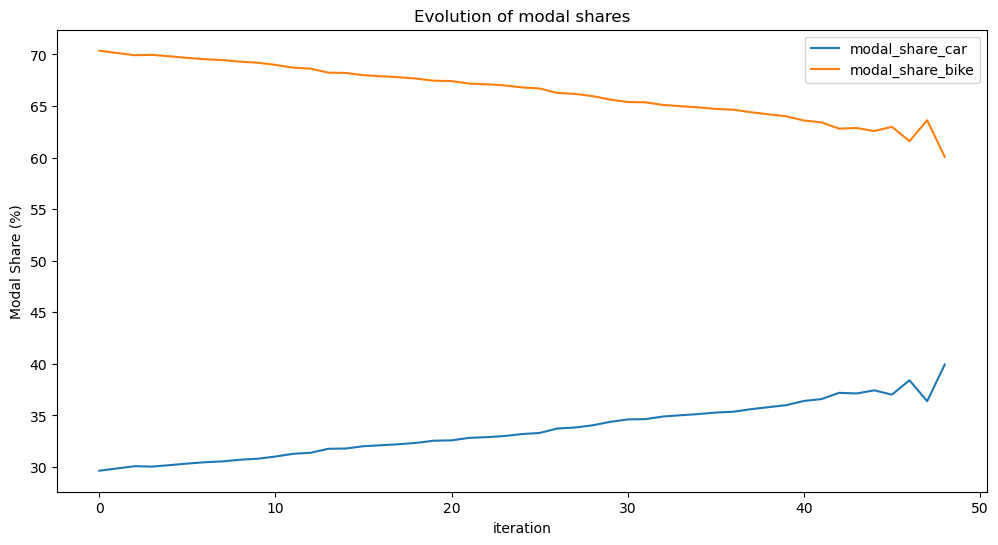

In [236]:
results_df.plot.line(x='iteration', y=['modal_share_car','modal_share_bike'], figsize=(12,6), title='Evolution of modal shares', ylabel='Modal Share (%)')
plt.show()

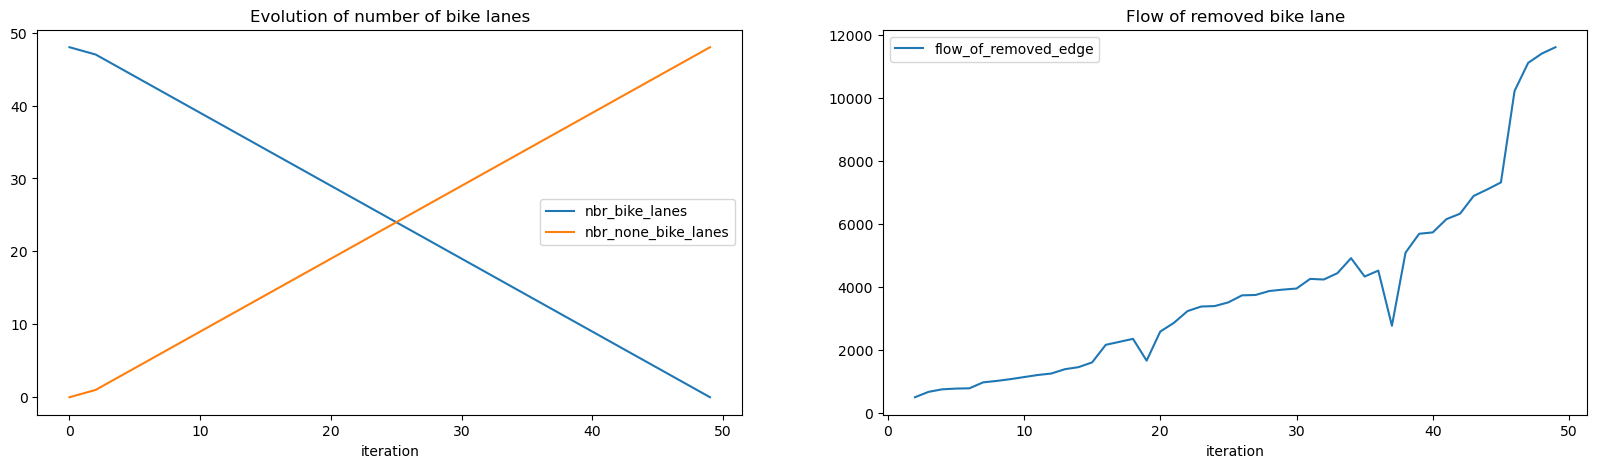

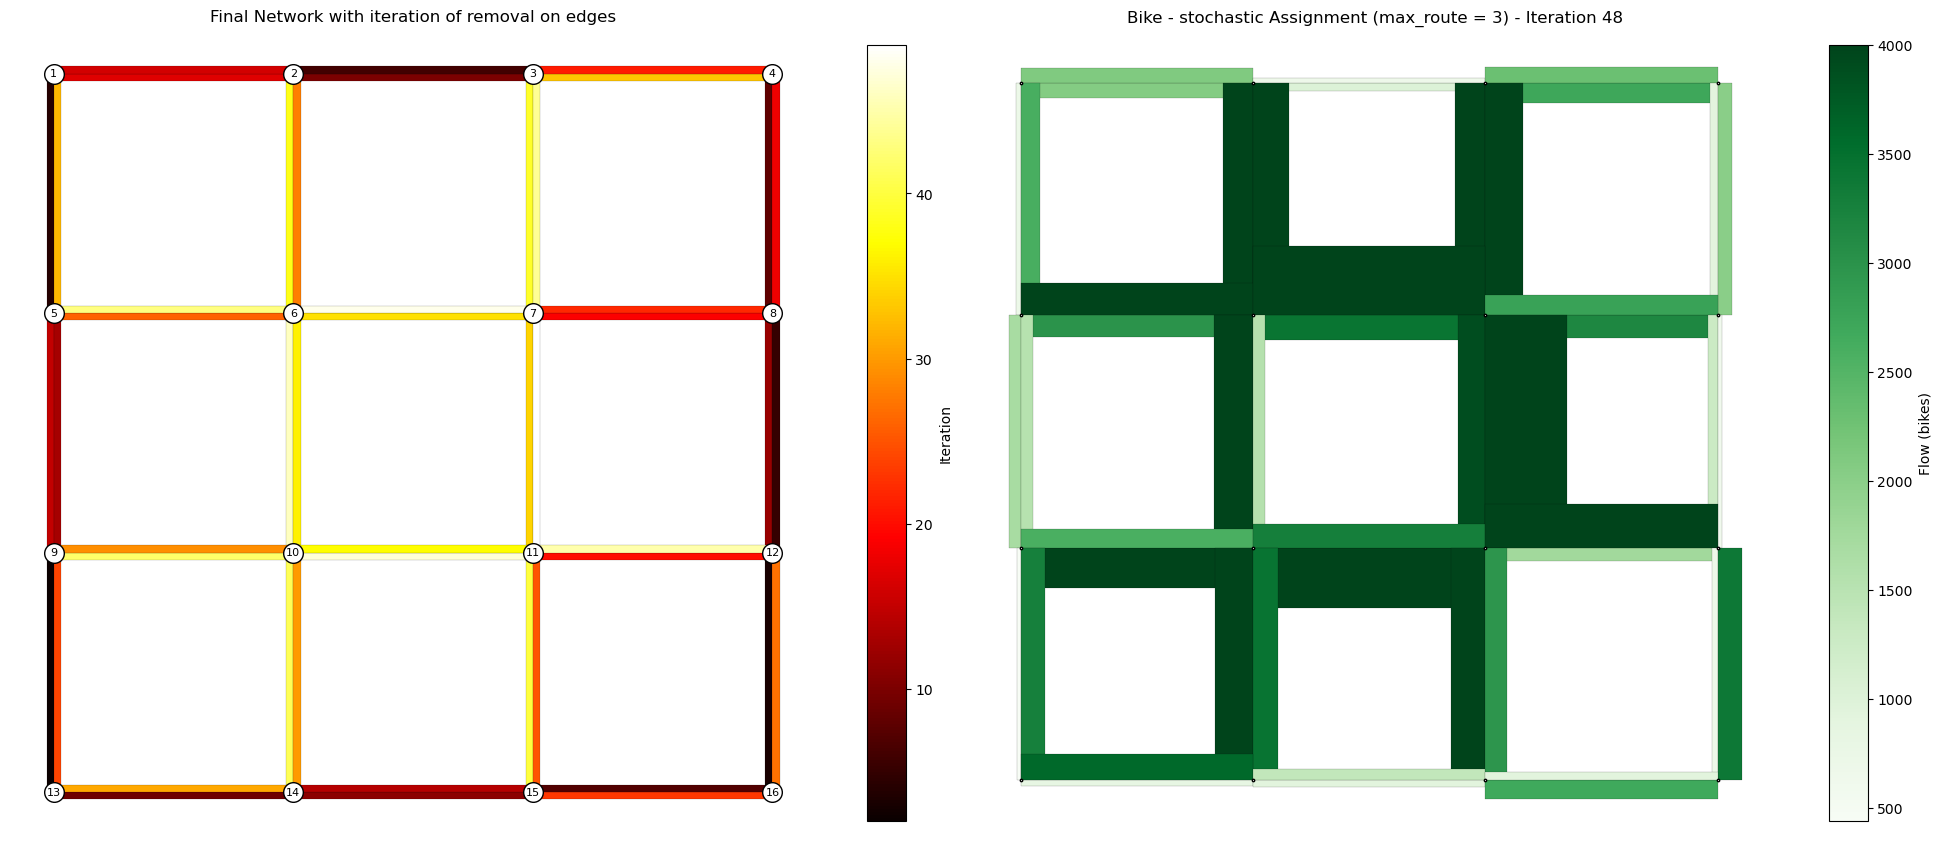

Proposed network with budget 11 has a flow coverage of 54.80%.


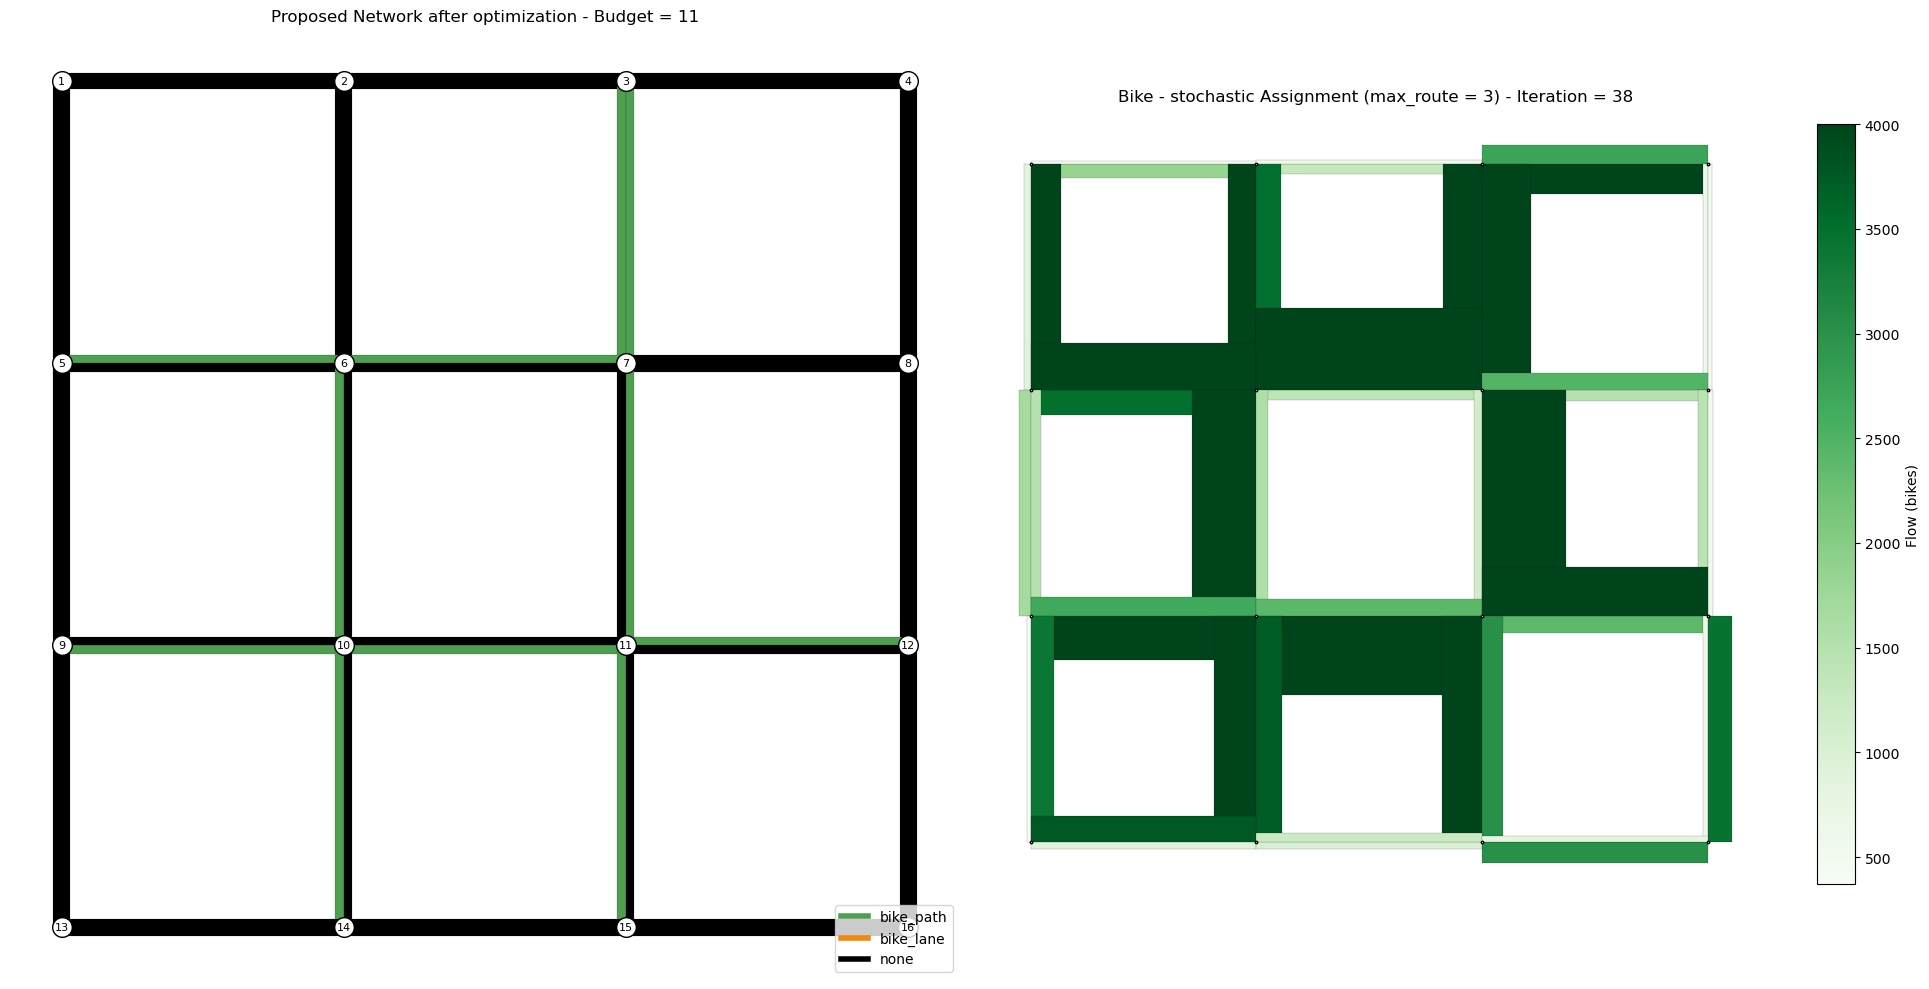

In [237]:
edge_df_final = edge_df_tri.copy()
results_df_exploded = results_df.explode('index_removed', ignore_index=True)
edge_df_final = pd.merge(edge_df_final, results_df_exploded[['iteration','index_removed']], left_index=True, right_on='index_removed', how='left')
fig, axes = plt.subplots(1,2, figsize=(20,5))
results_df.plot.line(x='iteration', y=['nbr_bike_lanes','nbr_none_bike_lanes'], title='Evolution of number of bike lanes', ax=axes[0])
results_df.plot.line(x='iteration', y='flow_of_removed_edge', title='Flow of removed bike lane', ax=axes[1])
plt.show()
fig, axes = plt.subplots(1,2, figsize=(20,10))
plot_network(edge_df_final, node_df, color_col_num='iteration', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True,  title='Final Network with iteration of removal on edges', ax=axes[0], cmap='hot')
plot_network(
        bike_results['network'], node_df,
        width_col='flow',
        color_col_num='flow',
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration {i}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000
    )
plt.show()  
edge_df_proposed = edge_df_final.copy()


budget = 11
iteration = len(edge_df_proposed) - budget + 1
edge_df_proposed.loc[edge_df_proposed['iteration']>iteration, "type_bike"] = "bike_path"
flow_coverage = edge_df_proposed[edge_df_proposed['type_bike'] == 'bike_path']['flow_bike_iteration_'+str(iteration)].sum()/edge_df_proposed['flow_bike_iteration_'+str(iteration)].sum()

fig, axes = plt.subplots(1,2, figsize=(20,10))
plot_network(edge_df_proposed, node_df, color_col_str='type_bike', base_width=1, width_scale=5, node_size=200, legend=True,  node_label=True,title='Proposed Network after optimization - Budget = '+str(budget), figsize=(10,10), edges_label_col='index', ax=axes[0])
plot_network(
        edge_df_proposed, node_df,
        width_col='flow_bike_iteration_'+str(iteration),
        color_col_num='flow_bike_iteration_'+str(iteration),
        cmap='Greens',
        title=f'Bike - stochastic Assignment (max_route = 3) - Iteration = {iteration}',
        node_size=3,
        colorbar_label='Flow (bikes)',
        base_width=0.1,
        width_scale=10,
        ax=axes[1],
        vmax=4000
    )
print(f"Proposed network with budget {budget} has a flow coverage of {flow_coverage*100:.2f}%.")


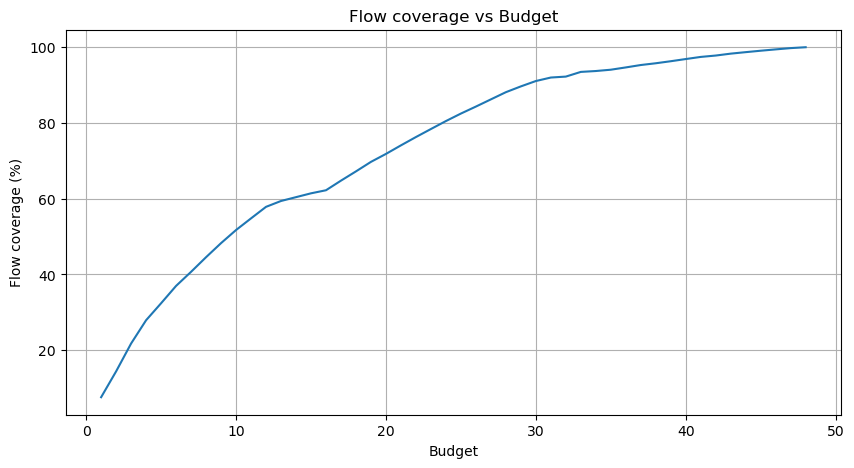

In [238]:
edge_df_proposed = edge_df_final.copy()
liste_budgets = []
liste_flow_coverage = []
for budget in range(1,49):
    iteration = len(edge_df_proposed) - budget + 1
    edge_df_proposed.loc[edge_df_proposed['iteration']>iteration, "type_bike"] = "bike_path"
    flow_coverage = edge_df_proposed[edge_df_proposed['type_bike'] == 'bike_path']['flow_bike_iteration_'+str(iteration)].sum()/edge_df_proposed['flow_bike_iteration_'+str(iteration)].sum()
    liste_budgets.append(budget)
    liste_flow_coverage.append(flow_coverage)
fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(liste_budgets, [fc*100 for fc in liste_flow_coverage])
ax.set_title("Flow coverage vs Budget")
ax.set_xlabel("Budget")
ax.set_ylabel("Flow coverage (%)")
ax.grid()
plt.show()

## $\beta$ and cutoff_prob parameters testing

--- Beta: 0.1, Cutoff Prob: 0.0 ---
Stochastic (bike) completed in 0.00s | TTT: 142
   a_node  b_node  length  capacity       flow  time  cost
0       1       2       1        10  66.524096     1     1
1       1       2       2        10  24.472847     2     2
2       1       2       3        10   9.003057     3     3
--- Beta: 0.5, Cutoff Prob: 0.0 ---
Stochastic (bike) completed in 0.00s | TTT: 142
   a_node  b_node  length  capacity       flow  time  cost
0       1       2       1        10  66.524096     1     1
1       1       2       2        10  24.472847     2     2
2       1       2       3        10   9.003057     3     3
--- Beta: 1.0, Cutoff Prob: 0.0 ---
Stochastic (bike) completed in 0.00s | TTT: 142
   a_node  b_node  length  capacity       flow  time  cost
0       1       2       1        10  66.524096     1     1
1       1       2       2        10  24.472847     2     2
2       1       2       3        10   9.003057     3     3
--- Beta: 2.0, Cutoff Prob: 0.0 ---
Stoc

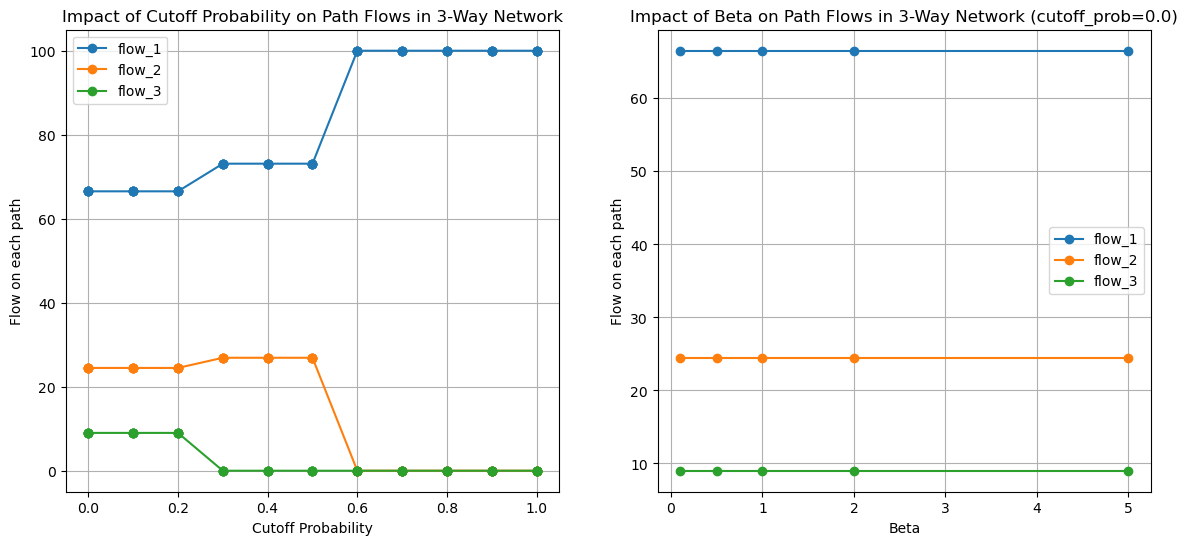

In [34]:
edge_df_3way = pd.DataFrame(columns=["a_node","b_node","length","capacity"])
edge_df_3way.loc[0] = [1,2,1,10]
edge_df_3way.loc[1] = [1,2,2,10]
edge_df_3way.loc[2] = [1,2,3,10]

node_df_3way = pd.DataFrame(columns=["node","x","y"])
node_df_3way.loc[0] = [1,0,0]
node_df_3way.loc[1] = [2,10,0]

od_matrix_3way = pd.DataFrame(columns=[1,2])
od_matrix_3way.loc[0] = [0,0]
od_matrix_3way.loc[1] = [0,100]
od_3way = convert_to_eaquilibrae_od_matrix(od_matrix_3way)

results_test_beta = pd.DataFrame(columns=['beta','cutoff_prob','flow_1', 'flow_2', 'flow_3'])
liste_beta = [0.1, 0.5, 1.0, 2.0, 5.0]
liste_cutoff_prob = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
i = 0
for cutoff_prob in liste_cutoff_prob:
    for beta in liste_beta:
        print(f"--- Beta: {beta}, Cutoff Prob: {cutoff_prob} ---")
        results_3way = ta_stochastic(
            edges_gdf=edge_df_3way,
            od_gdf=od_3way,
            mode='bike',
            time_field='length',
            cost_field='length',
            algorithm='bfsle',
            max_routes=3,
            capacity_field='capacity', 
            beta=beta,
            cutoff_prob=cutoff_prob,
        )

        print(results_3way['network'].head())
        results_test_beta.loc[i] = [beta, cutoff_prob,
                                    results_3way['network'].loc[(results_3way['network']['a_node']==1) & (results_3way['network']['b_node']==2) & (results_3way['network'].index==0), 'flow'].values[0],
                                    results_3way['network'].loc[(results_3way['network']['a_node']==1) & (results_3way['network']['b_node']==2) & (results_3way['network'].index==1), 'flow'].values[0],
                                    results_3way['network'].loc[(results_3way['network']['a_node']==1) & (results_3way['network']['b_node']==2) & (results_3way['network'].index==2), 'flow'].values[0]
                                ]
        i += 1

# Plotting the results

fig, axes = plt.subplots(1,2, figsize=(14,6))
results_test_beta.plot(x='cutoff_prob', y=['flow_1', 'flow_2', 'flow_3'], marker='o', ax=axes[0])
axes[0].set_xlabel('Cutoff Probability')
axes[0].set_ylabel('Flow on each path')
axes[0].set_title('Impact of Cutoff Probability on Path Flows in 3-Way Network')
axes[0].grid(True)
results_test_beta[results_test_beta['cutoff_prob'] == 0.0].plot(x='beta', y=['flow_1', 'flow_2', 'flow_3'], marker='o', ax=axes[1])
axes[1].set_xlabel('Beta')
axes[1].set_ylabel('Flow on each path')
axes[1].set_title('Impact of Beta on Path Flows in 3-Way Network (cutoff_prob=0.0)')
axes[1].grid(True)
plt.show()

In [38]:
results_test_beta = pd.DataFrame(columns=['beta','cutoff_prob','flow_coverage'])
liste_beta = [0.1, 0.5, 1.0, 2.0, 5.0]
liste_cutoff_prob = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
j = 0
for beta in liste_beta:
    for cutoff_prob in liste_cutoff_prob:
        print(f"--- Beta: {beta}, Cutoff Prob: {cutoff_prob} ---")
        edge_df_tri=edge_df_modif.copy().reset_index(drop=True)
        nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
        len_df = 30
        i = 0
        limit = 100
        nbr_bike_lanes = edge_df_modif['type_bike'].notnull().sum()
        nbr_none_bike_lanes = edge_df_modif['type_bike'].isnull().sum()
        results_df = pd.DataFrame({'iteration': [0],
                                'nbr_bike_lanes': nbr_bike_lanes,
                                'nbr_none_bike_lanes': nbr_none_bike_lanes})

        while nbr_bike_lanes > 0 and i < limit :
            i += 1
            print(f"\n--- Iteration {i} ---")
            print("➡️ Running traffic assignments...")
            print("➡️ Cars assignment...")
            
            name_col_flow_car = 'flow_car_iteration_'+str(i)
            name_col_flow_bike = 'flow_bike_iteration_'+str(i)

            # run car traffic assignment
            cars_results = ta_stochastic(edge_df_tri, od_car, mode='cars',
                        time_field='travel_time_cars', cost_field='length',
                        algorithm='bfsle', max_routes=1,
                        capacity_field='capacity_cars')
            edge_df_tri = cars_results['network'].copy()
            edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_car})

            print("✅ Cars assignment done.")
            print("➡️ Bikes assignment...")

            #recalculate bike infrastructure
            edge_df_tri = simple_bi_2(edge_df_tri, traffic_col='flow_car_iteration_1')

            #run bike traffic assignment
            bike_results = ta_stochastic(
                                        edge_df_tri, 
                                        od_bike, 
                                        mode='bikes',
                                        time_field='length_bi', 
                                        cost_field='length_bi',
                                        algorithm='bfsle', 
                                        max_routes=3,
                                        capacity_field='capacity_bikes',
                                        beta=beta,
                                        cutoff_prob=cutoff_prob
                                        )
            
            edge_df_tri = bike_results['network'].copy()
            edge_df_tri = edge_df_tri.rename(columns={'flow': name_col_flow_bike})

            print("✅ Bikes assignment done.")
            print("Traffic assignments completed.")

            #identify edges considered for removal
            edges_considered_for_removal = edge_df_tri[edge_df_tri['type_bike'].notna()]
            indexes_removed = pd.Index([])
            #select index of least used edge
            index_least_used = edges_considered_for_removal[name_col_flow_bike].sort_values(ascending=True).index[0]
            indexes_removed = indexes_removed.union(pd.Index([index_least_used]))
            #remove infrastructures from selected edges
            edge_df_tri.loc[indexes_removed, 'type_bike'] = None

            print(f"Iteration {i} - Removing bike lane on edge {indexes_removed} with flow {edge_df_tri.loc[index_least_used, name_col_flow_bike]}")
        
            nbr_bike_lanes = edge_df_tri['type_bike'].notnull().sum()
            nbr_none_bike_lanes = edge_df_tri['type_bike'].isnull().sum()
            flow_of_removed_edge = edge_df_tri.loc[index_least_used, name_col_flow_bike]
            results_df = pd.concat([results_df, 
                                    pd.DataFrame({'iteration': [i+1],'nbr_bike_lanes': nbr_bike_lanes,'nbr_none_bike_lanes': nbr_none_bike_lanes,'index_removed': [indexes_removed],'flow_of_removed_edge': [flow_of_removed_edge]})
                                    ], ignore_index=True)
            
        edge_df_final = edge_df_tri.copy()
        results_df_exploded = results_df.explode('index_removed', ignore_index=True)
        edge_df_final = pd.merge(edge_df_final, results_df_exploded[['iteration','index_removed']], left_index=True, right_on='index_removed', how='left')
        edge_df_proposed = edge_df_final.copy()

        budget = 10
        iteration = len(edge_df_proposed) - budget + 1
        edge_df_proposed.loc[edge_df_proposed['iteration']>iteration, "type_bike"] = "bike_path"
        flow_coverage = edge_df_proposed[edge_df_proposed['type_bike'] == 'bike_path']['flow_bike_iteration_'+str(iteration)].sum()/edge_df_proposed['flow_bike_iteration_'+str(iteration)].sum()
        results_test_beta.loc[j] = [beta, cutoff_prob, flow_coverage]
        j += 1


--- Beta: 0.1, Cutoff Prob: 0.0 ---

--- Iteration 1 ---
➡️ Running traffic assignments...
➡️ Cars assignment...
Stochastic (cars) completed in 0.00s | TTT: 1040
✅ Cars assignment done.
➡️ Bikes assignment...
Stochastic (bikes) completed in 0.00s | TTT: 18093845
✅ Bikes assignment done.
Traffic assignments completed.
Iteration 1 - Removing bike lane on edge Index([11], dtype='object') with flow 236.24317389667965

--- Iteration 2 ---
➡️ Running traffic assignments...
➡️ Cars assignment...
Stochastic (cars) completed in 0.00s | TTT: 1040
✅ Cars assignment done.
➡️ Bikes assignment...
Stochastic (bikes) completed in 0.00s | TTT: 18098789
✅ Bikes assignment done.
Traffic assignments completed.
Iteration 2 - Removing bike lane on edge Index([1], dtype='object') with flow 222.65223059571085

--- Iteration 3 ---
➡️ Running traffic assignments...
➡️ Cars assignment...
Stochastic (cars) completed in 0.00s | TTT: 1040
✅ Cars assignment done.
➡️ Bikes assignment...
Stochastic (bikes) completed i

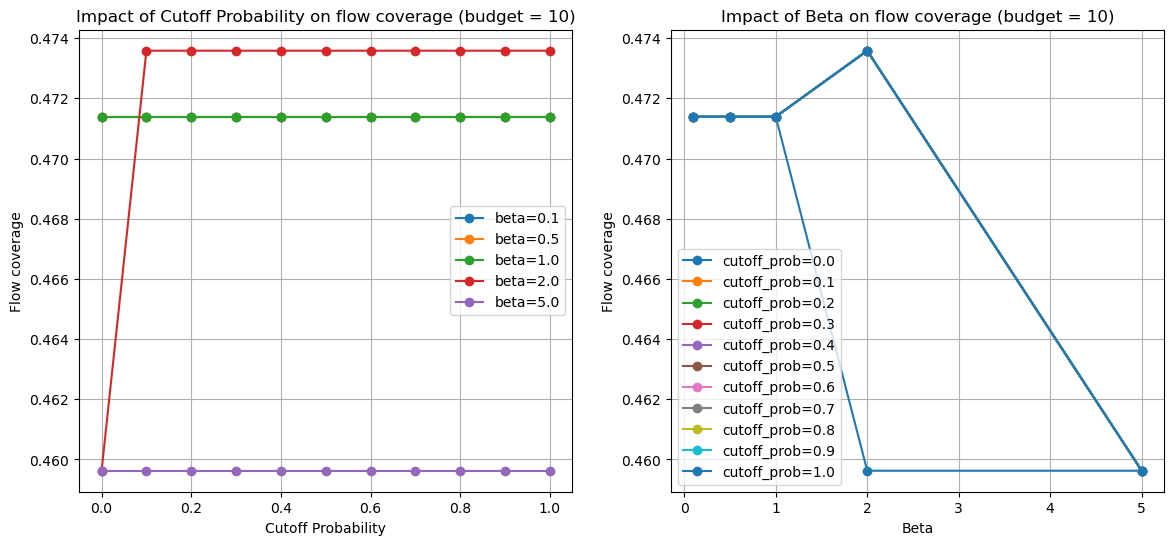

In [48]:
ig, axes = plt.subplots(1,2, figsize=(14,6))
results_test_beta[results_test_beta['beta'] == 0.1].plot(x='cutoff_prob', y='flow_coverage', marker='o', ax=axes[0], label='beta=0.1')
results_test_beta[results_test_beta['beta'] == 0.5].plot(x='cutoff_prob', y='flow_coverage', marker='o', ax=axes[0], label='beta=0.5')
results_test_beta[results_test_beta['beta'] == 1.0].plot(x='cutoff_prob', y='flow_coverage', marker='o', ax=axes[0], label='beta=1.0')
results_test_beta[results_test_beta['beta'] == 2.0].plot(x='cutoff_prob', y='flow_coverage', marker='o', ax=axes[0], label='beta=2.0')
results_test_beta[results_test_beta['beta'] == 5.0].plot(x='cutoff_prob', y='flow_coverage', marker='o', ax=axes[0], label='beta=5.0')
axes[0].set_xlabel('Cutoff Probability')
axes[0].set_ylabel('Flow coverage')
axes[0].set_title('Impact of Cutoff Probability on flow coverage (budget = 10)')
axes[0].grid(True)
for cutoff_prob in liste_cutoff_prob:
    results_test_beta[results_test_beta['cutoff_prob'] == cutoff_prob].plot(x='beta', y='flow_coverage', marker='o', ax=axes[1], label=f'cutoff_prob={cutoff_prob}')
axes[1].set_xlabel('Beta')
axes[1].set_ylabel('Flow coverage')
axes[1].set_title('Impact of Beta on flow coverage (budget = 10)')
axes[1].grid(True)
plt.show()